In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
from skgarden import MondrianForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
from sklearn.metrics import mean_squared_error

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams

import pandas as pd
import time
from sklearn.metrics import r2_score
import rrcf

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def score_for_res(pred, trueval) :
    u2 = (pred-trueval)**2
    v2 = (trueval-trueval.mean())**2
    
    return 1-(u2.sum()/v2.sum())

In [3]:
def partial_train(mtr, X_test, y_test):
    y_pred, y_std = mtr.predict(X_test, return_std=True)
    mtr.partial_fit(X_test, y_test)
    #print('pred : %f, std: %f, y: %f'%(y_pred, y_std, y_test))
    return y_pred, y_std

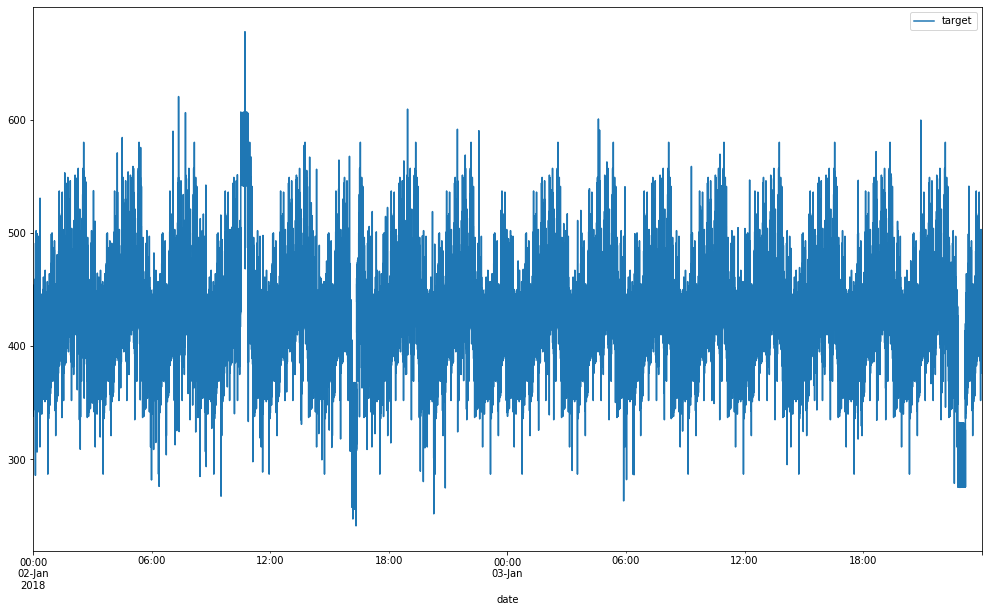

In [4]:
network = pd.read_csv('C:/Users/HakkyuKim/Desktop/yeonwoo/challenge/intial_trainig_stage.csv', index_col='date', parse_dates=['date'])
network.head()

rcParams['figure.figsize'] = 17,10
network.describe()
network.plot()

In [5]:
#construct forest of empty RCTrees

num_trees = 40
shingle_size = 60
tree_size = 256


forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

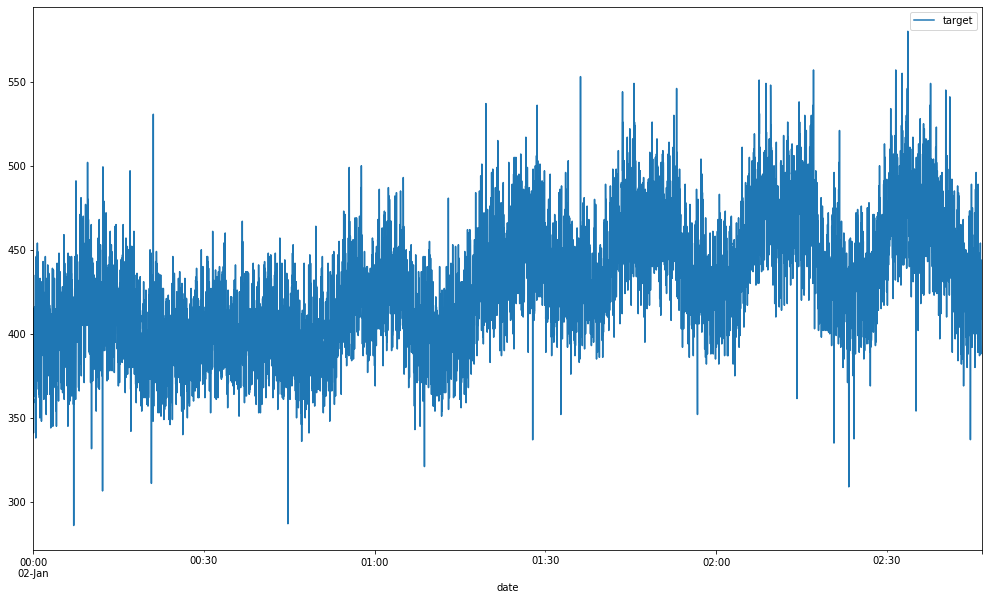

In [6]:
#train data 정제
ntw_clean = network.copy()

train_len = 10000
ntw_clean = ntw_clean[:train_len]

avg_codisp = {}
train_mean = ntw_clean.mean()

ntw_clean.plot()

In [7]:
for index in range(0, train_len) :
    point = ntw_clean[index:index+1] #get one by one
    
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(point, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data
        
        ntw_clean.iloc[index] = train_mean
        


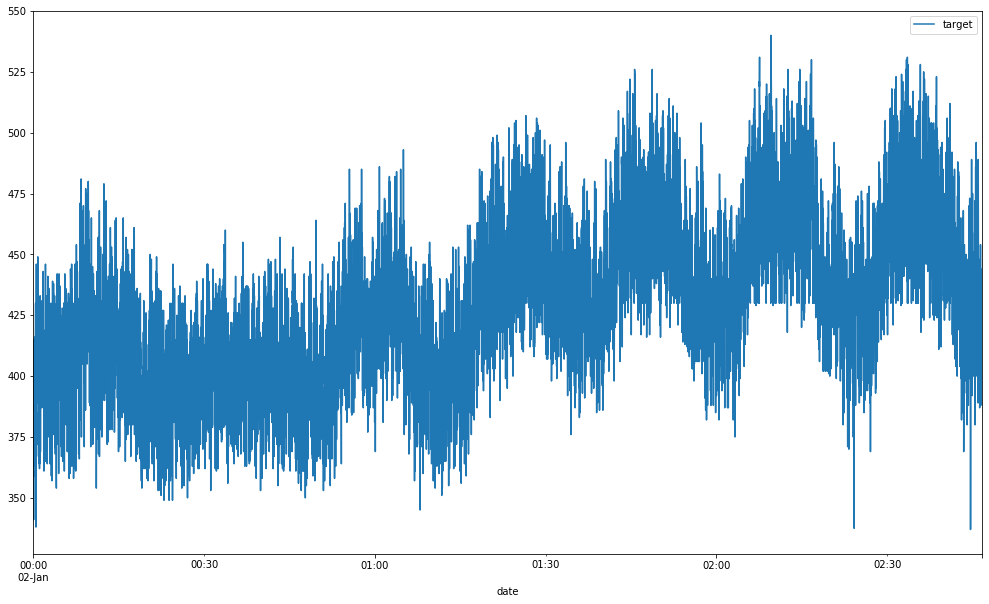

In [8]:

ntw_clean.plot()


In [9]:
avg_codisp

{0: 0.0,
 1: 1.0000000000000004,
 2: 1.0000000000000004,
 3: 2.3749999999999996,
 4: 1.3,
 5: 1.3624999999999996,
 6: 1.2000000000000002,
 7: 2.5374999999999996,
 8: 4.387499999999999,
 9: 2.287500000000001,
 10: 1.1624999999999999,
 11: 3.1458333333333344,
 12: 3.208333333333332,
 13: 2.183333333333333,
 14: 3.5187500000000016,
 15: 2.1958333333333333,
 16: 1.954166666666667,
 17: 1.7625,
 18: 3.2974999999999985,
 19: 2.4625000000000004,
 20: 2.826666666666666,
 21: 2.68095238095238,
 22: 2.166369047619048,
 23: 2.5749999999999997,
 24: 11.012499999999994,
 25: 2.75625,
 26: 2.3133766233766235,
 27: 8.032916666666669,
 28: 1.5458333333333332,
 29: 2.287083333333334,
 30: 2.0179112554112555,
 31: 6.247142857142859,
 32: 9.239583333333334,
 33: 3.153776154401155,
 34: 2.0591666666666675,
 35: 2.58937728937729,
 36: 5.182235750360748,
 37: 3.467819264069264,
 38: 3.759420163170164,
 39: 1.970892857142858,
 40: 1.834744935254805,
 41: 4.3546013708513716,
 42: 2.786382783882785,
 43: 2.471

In [10]:
#train set만들기
tmp = ntw_clean.shift(1)
tmp2 = ntw_clean.shift(2)
tmp3 = ntw_clean.shift(3)

ntw_prev = ntw_clean.copy()
ntw_prev['prev1'] = tmp['target']
ntw_prev['prev2'] = tmp2['target']
ntw_prev['prev3'] = tmp3['target']

ntw_prev = ntw_prev[4:]
ntw_prev.tail()

,target,prev1,prev2,prev3
date,,,,
2018-01-02 02:46:35,409.0,416.0,437.0,443.0
2018-01-02 02:46:36,412.0,409.0,416.0,437.0
2018-01-02 02:46:37,418.0,412.0,409.0,416.0
2018-01-02 02:46:38,425.0,418.0,412.0,409.0
2018-01-02 02:46:39,442.0,425.0,418.0,412.0


In [11]:


#training은 clean한 data로, test는 clean하지 않은 data를 rrcf로 다시 정제하면서 진행할거임



#xt = [network[10000:10001], network.iloc[10001], network.iloc[10002]]
xt = pd.Series()


In [12]:
type(xt)
print(xt)

Series([], dtype: float64)


In [13]:
mfr = MondrianForestRegressor(random_state = 1, n_estimators=100, bootstrap=True)
for i in range(3, len(ntw_clean)):
    X_train = pd.Series()
    X_train['prev1'] = ntw_clean[i-3:i-2]['target']
    X_train['prev2'] = ntw_clean[i-2:i-1]['target']
    X_train['prev3'] = ntw_clean[i-1:i]['target']
    y_train = ntw_clean[i:i+1]['target']
    mfr.partial_fit(X_train.values.reshape(1, -1), y_train)

prediction = np.array([])
stdeviation = np.array([])

#일단 Test mean은 train mean과 같게 시작
test_sum = ntw_clean.sum()
test_num = ntw_clean.size
yt = 0



In [14]:
cleaned = np.array([])
for tree in forest :
    print(tree.leaves.keys())

dict_keys([0, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 99

In [ ]:
for i in range(0, 50000) :
    yp = yt
    if (i == 0) : 
        yp = None
    
    yt = network[10004+i:10004+i+1]['target']
    xt['prev1'] = network[10001+i:10001+i+1]['target']
    xt['prev2'] = network[10002+i:10002+i+1]['target']
    xt['prev3'] = network[10003+i:10003+i+1]['target']

    #train의 index가 9999에서 끝났으니까, 10000부터 시작
    index = i+10000
    print(index)
    #yt의 anomaly여부 판단
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(point, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    print(z)
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data
        yt = test_sum/test_num
    
    cleaned = np.append(cleaned, [yt])
    y_pred, y_std = partial_train(mfr, xt.values.reshape(1, -1), yt)
    #과거 3개만 저장
    np.roll(xt, -1)
    xt[2] = yt
    
    test_sum += yt
    test_num += 1
    
    prediction = np.append(prediction, [y_pred])
    stdeviation = np.append(stdeviation, [y_std])
    
    

10000
-0.2138996762951812
10001
-0.30453337394221264
10002
-0.35199463994066227
10003
-0.38346429774995827
10004
-0.4060506818410316
10005
-0.4242624967948917
10006
-0.43916846842533175
10007
-0.45278916949203596
10008
-0.4630935618535813
10009
-0.47166829403499416
10010
-0.4793868744584561
10011
-0.4858656466111849
10012
-0.4924423181076572
10013
-0.4990813264819992
10014
-0.5042333768170584
10015
-0.5081205246248822
10016
-0.5122042641808333
10017
-0.5148196646203815
10018
-0.5179199900042133
10019
-0.5210483891997303
10020
-0.5236021569949009
10021
-0.5262378491309253
10022
-0.528550915726363
10023
-0.5308756762930104
10024
-0.5308417364201239
10025
-0.5325548723620004
10026
-0.5342354757339979
10027
-0.5363793812409463
10028
-0.5383846261254649
10029
-0.5389310961324465
10030
-0.5409032342809426
10031
-0.542781660342062
10032
-0.5445093877714503
10033
-0.5461649664219324
10034
-0.5474883336215839
10035
-0.5491491275953585
10036
-0.5502241461723003
10037
-0.551666806761051
10038
-0.

10317
-0.7814681669538678
10318
-0.7814094700626084
10319
-0.7813507570246773
10320
-0.7812920284289073
10321
-0.7812332848487262
10322
-0.781174526842654
10323
-0.7811157549547783
10324
-0.7810569697152161
10325
-0.7809981716405529
10326
-0.7809393612342701
10327
-0.7808805389871524
10328
-0.7808217053776825
10329
-0.7807628608724196
10330
-0.7807040059263664
10331
-0.7806451409833195
10332
-0.7805862664762085
10333
-0.7805273828274251
10334
-0.7804684904491356
10335
-0.7804095897435864
10336
-0.7803506811033977
10337
-0.7802917649118445
10338
-0.780232841543131
10339
-0.7801739113626538
10340
-0.7801149747272562
10341
-0.7800560319854734
10342
-0.7799970834777692
10343
-0.7799381295367668
10344
-0.779879170487468
10345
-0.7798202066474688
10346
-0.7797612383271644
10347
-0.7797022658299505
10348
-0.7796432894524152
10349
-0.7795843094845278
10350
-0.7795253262098165
10351
-0.779466339905546
10352
-0.7794073508428848
10353
-0.7793483592870702
10354
-0.7792893654975662
10355
-0.7792303

10635
-0.762903377313785
10636
-0.7628466456962035
10637
-0.762789926732903
10638
-0.7627332204191797
10639
-0.7626765267503319
10640
-0.7626198457216616
10641
-0.7625631773284721
10642
-0.7625065215660696
10643
-0.7624498784297625
10644
-0.7623932479148623
10645
-0.7623366300166817
10646
-0.7622800247305377
10647
-0.7622234320517475
10648
-0.7621668519756325
10649
-0.7621102844975156
10650
-0.7620537296127228
10651
-0.7619971873165818
10652
-0.7619406576044232
10653
-0.7618841404715799
10654
-0.7618276359133873
10655
-0.7617711439251829
10656
-0.761714664502307
10657
-0.7616581976401023
10658
-0.7616017433339138
10659
-0.7615453015790887
10660
-0.761488872370977
10661
-0.7614324557049308
10662
-0.761376051576305
10663
-0.7613196599804561
10664
-0.7612632809127443
10665
-0.761206914368531
10666
-0.7611505603431807
10667
-0.7610942188320597
10668
-0.7610378898305377
10669
-0.7609815733339856
10670
-0.7609252693377775
10671
-0.7608689778372897
10672
-0.7608126988279007
10673
-0.760756432

10952
-0.7455294900333218
10953
-0.7454765464640564
10954
-0.7454236141725077
10955
-0.7453706931546724
10956
-0.7453177834065493
10957
-0.7452648849241392
10958
-0.7452119977034447
10959
-0.7451591217404704
10960
-0.7451062570312228
10961
-0.7450534035717109
10962
-0.7450005613579451
10963
-0.7449477303859379
10964
-0.744894910651704
10965
-0.7448421021512599
10966
-0.7447893048806243
10967
-0.7447365188358176
10968
-0.7446837440128622
10969
-0.7446309804077827
10970
-0.7445782280166054
10971
-0.7445254868353586
10972
-0.7444727568600729
10973
-0.7444200380867804
10974
-0.7443673305115156
10975
-0.7443146341303147
10976
-0.7442619489392158
10977
-0.7442092749342593
10978
-0.744156612111487
10979
-0.7441039604669435
10980
-0.7440513199966745
10981
-0.7439986906967283
10982
-0.7439460725631545
10983
-0.7438934655920053
10984
-0.7438408697793346
10985
-0.7437882851211983
10986
-0.7437357116136538
10987
-0.7436831492527614
10988
-0.7436305980345824
10989
-0.7435780579551807
10990
-0.74352

11277
-0.7288947805874407
11278
-0.7288453022272282
11279
-0.7287958339416212
11280
-0.7287463757272014
11281
-0.7286969275805517
11282
-0.7286474894982573
11283
-0.7285980614769044
11284
-0.7285486435130809
11285
-0.7284992356033767
11286
-0.728449837744383
11287
-0.7284004499326923
11288
-0.7283510721648997
11289
-0.7283017044376009
11290
-0.728252346747394
11291
-0.728202999090878
11292
-0.7281536614646541
11293
-0.7281043338653246
11294
-0.7280550162894938
11295
-0.7280057087337675
11296
-0.7279564111947532
11297
-0.7279071236690599
11298
-0.7278578461532981
11299
-0.72780857864408
11300
-0.7277593211380196
11301
-0.7277100736317321
11302
-0.7276608361218346
11303
-0.727611608604946
11304
-0.7275623910776862
11305
-0.7275131835366772
11306
-0.7274639859785422
11307
-0.7274147983999066
11308
-0.7273656207973968
11309
-0.7273164531676412
11310
-0.7272672955072693
11311
-0.7272181478129129
11312
-0.7271690100812048
11313
-0.7271198823087797
11314
-0.7270707644922735
11315
-0.727021656

11598
-0.7135116682314252
11599
-0.7134652567038826
11600
-0.7134188542319023
11601
-0.7133724608125395
11602
-0.7133260764428511
11603
-0.7132797011198955
11604
-0.7132333348407321
11605
-0.7131869776024221
11606
-0.7131406294020277
11607
-0.7130942902366126
11608
-0.7130479601032418
11609
-0.7130016389989813
11610
-0.712955326920899
11611
-0.7129090238660637
11612
-0.7128627298315459
11613
-0.7128164448144171
11614
-0.7127701688117504
11615
-0.7127239018206197
11616
-0.7126776438381008
11617
-0.7126313948612709
11618
-0.7125851548872082
11619
-0.7125389239129921
11620
-0.7124927019357036
11621
-0.7124464889524249
11622
-0.7124002849602398
11623
-0.712354089956233
11624
-0.7123079039374907
11625
-0.7122617269011005
11626
-0.7122155588441514
11627
-0.7121693997637334
11628
-0.7121232496569381
11629
-0.7120771085208584
11630
-0.7120309763525882
11631
-0.7119848531492231
11632
-0.7119387389078601
11633
-0.7118926336255968
11634
-0.7118465372995331
11635
-0.7118004499267695
11636
-0.71175

11922
-0.6989322201464606
11923
-0.6988885957408966
11924
-0.6988449795028681
11925
-0.6988013714298266
11926
-0.6987577715192251
11927
-0.6987141797685176
11928
-0.6986705961751591
11929
-0.6986270207366058
11930
-0.6985834534503149
11931
-0.698539894313745
11932
-0.6984963433243551
11933
-0.6984528004796062
11934
-0.69840926577696
11935
-0.6983657392138793
11936
-0.6983222207878282
11937
-0.6982787104962713
11938
-0.6982352083366751
11939
-0.6981917143065066
11940
-0.6981482284032344
11941
-0.6981047506243278
11942
-0.6980612809672573
11943
-0.6980178194294946
11944
-0.6979743660085127
11945
-0.6979309207017851
11946
-0.697887483506787
11947
-0.6978440544209943
11948
-0.6978006334418843
11949
-0.6977572205669352
11950
-0.6977138157936262
11951
-0.6976704191194381
11952
-0.6976270305418523
11953
-0.6975836500583514
11954
-0.6975402776664191
11955
-0.6974969133635404
11956
-0.697453557147201
11957
-0.6974102090148883
11958
-0.6973668689640897
11959
-0.6973235369922952
11960
-0.69728021

12246
-0.6852114594676735
12247
-0.6851703539832361
12248
-0.6851292558956024
12249
-0.6850881652025539
12250
-0.6850470819018735
12251
-0.6850060059913448
12252
-0.6849649374687526
12253
-0.6849238763318828
12254
-0.6848828225785213
12255
-0.6848417762064561
12256
-0.6848007372134753
12257
-0.6847597055973683
12258
-0.6847186813559254
12259
-0.684677664486938
12260
-0.6846366549881975
12261
-0.6845956528574972
12262
-0.6845546580926316
12263
-0.6845136706913949
12264
-0.6844726906515832
12265
-0.6844317179709932
12266
-0.6843907526474226
12267
-0.6843497946786697
12268
-0.6843088440625342
12269
-0.6842679007968163
12270
-0.6842269648793176
12271
-0.6841860363078404
12272
-0.6841451150801875
12273
-0.6841042011941632
12274
-0.6840632946475725
12275
-0.6840223954382214
12276
-0.6839815035639165
12277
-0.6839406190224658
12278
-0.6838997418116781
12279
-0.6838588719293627
12280
-0.68381800937333
12281
-0.6837771541413918
12282
-0.6837363062313605
12283
-0.6836954656410489
12284
-0.683654

-0.6723459357498358
12569
-0.6723071023223176
12570
-0.672268275622858
12571
-0.6722294556495142
12572
-0.6721906424003445
12573
-0.6721518358734079
12574
-0.6721130360667643
12575
-0.6720742429784742
12576
-0.672035456606599
12577
-0.6719966769492006
12578
-0.6719579040043424
12579
-0.6719191377700879
12580
-0.6718803782445016
12581
-0.6718416254256487
12582
-0.6718028793115954
12583
-0.6717641399004084
12584
-0.6717254071901554
12585
-0.671686681178905
12586
-0.671647961864726
12587
-0.6716092492456885
12588
-0.6715705433198637
12589
-0.6715318440853222
12590
-0.671493151540137
12591
-0.671454465682381
12592
-0.6714157865101282
12593
-0.6713771140214528
12594
-0.6713384482144307
12595
-0.6712997890871377
12596
-0.671261136637651
12597
-0.6712224908640482
12598
-0.6711838517644076
12599
-0.6711452193368092
12600
-0.6711065935793322
12601
-0.671067974490058
12602
-0.671029362067068
12603
-0.6709907563084444
12604
-0.6709521572122706
12605
-0.6709135647766303
12606
-0.6708749789996086
1

12886
-0.6603260247835715
12887
-0.6602892369724994
12888
-0.6602524553092642
12889
-0.6602156797921541
12890
-0.6601789104194573
12891
-0.6601421471894632
12892
-0.6601053901004614
12893
-0.6600686391507428
12894
-0.6600318943385982
12895
-0.6599951556623196
12896
-0.6599584231201997
12897
-0.6599216967105315
12898
-0.6598849764316088
12899
-0.6598482622817262
12900
-0.659811554259179
12901
-0.6597748523622627
12902
-0.6597381565892741
12903
-0.6597014669385104
12904
-0.6596647834082691
12905
-0.659628105996849
12906
-0.6595914347025491
12907
-0.6595547695236694
12908
-0.6595181104585102
12909
-0.6594814575053726
12910
-0.6594448106625586
12911
-0.6594081699283705
12912
-0.6593715353011113
12913
-0.6593349067790851
12914
-0.6592982843605962
12915
-0.6592616680439497
12916
-0.6592250578274513
12917
-0.6591884537094075
12918
-0.6591518556881254
12919
-0.6591152637619125
12920
-0.6590786779290775
12921
-0.6590420981879292
12922
-0.6590055245367775
12923
-0.6589689569739325
12924
-0.65893

13205
-0.648893635175802
13206
-0.6488587251239358
13207
-0.6488238207058772
13208
-0.6487889219201111
13209
-0.6487540287651224
13210
-0.6487191412393978
13211
-0.6486842593414234
13212
-0.6486493830696862
13213
-0.6486145124226743
13214
-0.6485796473988759
13215
-0.6485447879967794
13216
-0.6485099342148749
13217
-0.6484750860516518
13218
-0.6484402435056009
13219
-0.6484054065752134
13220
-0.6483705752589806
13221
-0.6483357495553953
13222
-0.6483009294629497
13223
-0.6482661149801376
13224
-0.6482313061054528
13225
-0.6481965028373899
13226
-0.6481617051744437
13227
-0.6481269131151103
13228
-0.6480921266578855
13229
-0.6480573458012662
13230
-0.64802257054375
13231
-0.6479878008838343
13232
-0.6479530368200179
13233
-0.6479182783508
13234
-0.6478835254746796
13235
-0.6478487781901572
13236
-0.6478140364957337
13237
-0.6477793003899102
13238
-0.6477445698711884
13239
-0.6477098449380709
13240
-0.6476751255890607
13241
-0.6476404118226611
13242
-0.6476057036373765
13243
-0.647571001

13529
-0.6378693127803813
13530
-0.6378361518841594
13531
-0.6378029961592041
13532
-0.6377698456041712
13533
-0.6377367002177173
13534
-0.6377035599984997
13535
-0.6376704249451757
13536
-0.6376372950564033
13537
-0.6376041703308414
13538
-0.6375710507671486
13539
-0.6375379363639847
13540
-0.6375048271200093
13541
-0.6374717230338836
13542
-0.6374386241042678
13543
-0.6374055303298237
13544
-0.6373724417092131
13545
-0.6373393582410987
13546
-0.6373062799241432
13547
-0.63727320675701
13548
-0.6372401387383632
13549
-0.6372070758668669
13550
-0.6371740181411859
13551
-0.6371409655599857
13552
-0.6371079181219322
13553
-0.6370748758256917
13554
-0.6370418386699307
13555
-0.6370088066533167
13556
-0.6369757797745176
13557
-0.6369427580322012
13558
-0.6369097414250365
13559
-0.636876729951693
13560
-0.63684372361084
13561
-0.6368107224011477
13562
-0.6367777263212868
13563
-0.6367447353699284
13564
-0.6367117495457443
13565
-0.6366787688474065
13566
-0.6366457932735873
13567
-0.63661282

-0.6275462770445671
13849
-0.6275147001445879
13850
-0.6274831280107923
13851
-0.6274515606419814
13852
-0.6274199980369569
13853
-0.6273884401945207
13854
-0.6273568871134753
13855
-0.6273253387926233
13856
-0.6272937952307681
13857
-0.6272622564267132
13858
-0.6272307223792628
13859
-0.6271991930872213
13860
-0.6271676685493935
13861
-0.627136148764585
13862
-0.6271046337316014
13863
-0.6270731234492489
13864
-0.6270416179163341
13865
-0.6270101171316638
13866
-0.6269786210940458
13867
-0.6269471298022876
13868
-0.6269156432551978
13869
-0.6268841614515848
13870
-0.6268526843902578
13871
-0.6268212120700264
13872
-0.6267897444897004
13873
-0.6267582816480902
13874
-0.6267268235440067
13875
-0.626695370176261
13876
-0.6266639215436648
13877
-0.62663247764503
13878
-0.626601038479169
13879
-0.6265696040448948
13880
-0.6265381743410208
13881
-0.6265067493663604
13882
-0.6264753291197279
13883
-0.6264439135999377
13884
-0.626412502805805
13885
-0.626381096736145
13886
-0.6263496953897731

-0.6176184077757629
14171
-0.6175883058734277
14172
-0.6175582083720439
14173
-0.6175281152705392
14174
-0.6174980265678419
14175
-0.6174679422628804
14176
-0.6174378623545832
14177
-0.6174077868418798
14178
-0.6173777157236997
14179
-0.6173476489989729
14180
-0.6173175866666293
14181
-0.6172875287256001
14182
-0.617257475174816
14183
-0.6172274260132083
14184
-0.6171973812397089
14185
-0.6171673408532498
14186
-0.6171373048527637
14187
-0.6171072732371833
14188
-0.6170772460054416
14189
-0.6170472231564722
14190
-0.6170172046892094
14191
-0.616987190602587
14192
-0.61695718089554
14193
-0.6169271755670033
14194
-0.6168971746159121
14195
-0.6168671780412025
14196
-0.6168371858418102
14197
-0.6168071980166719
14198
-0.6167772145647245
14199
-0.6167472354849047
14200
-0.6167172607761507
14201
-0.6166872904374001
14202
-0.616657324467591
14203
-0.6166273628656623
14204
-0.616597405630553
14205
-0.6165674527612022
14206
-0.6165375042565497
14207
-0.6165075601155356
14208
-0.616477620337100

14492
-0.6081472861593324
14493
-0.6081185478951016
14494
-0.6080898137046031
14495
-0.6080610835868748
14496
-0.6080323575409545
14497
-0.6080036355658807
14498
-0.6079749176606919
14499
-0.6079462038244269
14500
-0.6079174940561252
14501
-0.607888788354826
14502
-0.6078600867195696
14503
-0.6078313891493958
14504
-0.6078026956433454
14505
-0.6077740062004592
14506
-0.6077453208197783
14507
-0.607716639500344
14508
-0.6076879622411984
14509
-0.6076592890413832
14510
-0.6076306198999409
14511
-0.6076019548159147
14512
-0.6075732937883471
14513
-0.6075446368162818
14514
-0.6075159838987622
14515
-0.6074873350348324
14516
-0.6074586902235367
14517
-0.6074300494639199
14518
-0.6074014127550266
14519
-0.6073727800959023
14520
-0.6073441514855925
14521
-0.6073155269231432
14522
-0.6072869064076004
14523
-0.6072582899380108
14524
-0.6072296775134209
14525
-0.6072010691328782
14526
-0.60717246479543
14527
-0.6071438645001241
14528
-0.6071152682460085
14529
-0.6070866760321317
14530
-0.6070580

14812
-0.5991538912583373
14813
-0.5991264091358586
14814
-0.599098930794701
14815
-0.5990714562339976
14816
-0.5990439854528817
14817
-0.5990165184504868
14818
-0.5989890552259464
14819
-0.5989615957783948
14820
-0.5989341401069662
14821
-0.5989066882107954
14822
-0.5988792400890172
14823
-0.5988517957407666
14824
-0.5988243551651795
14825
-0.5987969183613913
14826
-0.5987694853285379
14827
-0.5987420560657558
14828
-0.5987146305721814
14829
-0.5986872088469516
14830
-0.5986597908892036
14831
-0.5986323766980746
14832
-0.5986049662727024
14833
-0.5985775596122249
14834
-0.5985501567157804
14835
-0.5985227575825072
14836
-0.5984953622115442
14837
-0.5984679706020304
14838
-0.5984405827531052
14839
-0.5984131986639081
14840
-0.598385818333579
14841
-0.598358441761258
14842
-0.5983310689460857
14843
-0.5983036998872026
14844
-0.5982763345837496
14845
-0.5982489730348682
14846
-0.5982216152396999
14847
-0.5981942611973863
14848
-0.5981669109070696
14849
-0.5981395643678921
14850
-0.598112

15132
-0.5905480360332294
15133
-0.5905217211371736
15134
-0.5904954097585897
15135
-0.5904691018966942
15136
-0.5904427975507036
15137
-0.5904164967198352
15138
-0.590390199403306
15139
-0.5903639056003334
15140
-0.5903376153101348
15141
-0.5903113285319286
15142
-0.5902850452649326
15143
-0.5902587655083654
15144
-0.5902324892614456
15145
-0.5902062165233919
15146
-0.5901799472934237
15147
-0.5901536815707602
15148
-0.5901274193546211
15149
-0.5901011606442261
15150
-0.5900749054387955
15151
-0.5900486537375497
15152
-0.5900224055397089
15153
-0.5899961608444941
15154
-0.5899699196511267
15155
-0.5899436819588276
15156
-0.5899174477668185
15157
-0.5898912170743212
15158
-0.5898649898805578
15159
-0.5898387661847505
15160
-0.5898125459861218
15161
-0.5897863292838946
15162
-0.5897601160772918
15163
-0.5897339063655367
15164
-0.5897077001478527
15165
-0.5896814974234635
15166
-0.5896552981915933
15167
-0.5896291024514663
15168
-0.5896029102023066
15169
-0.5895767214433393
15170
-0.5895

15453
-0.582277436000352
15454
-0.5822522112625557
15455
-0.5822269898027445
15456
-0.5822017716202086
15457
-0.5821765567142384
15458
-0.5821513450841244
15459
-0.5821261367291571
15460
-0.5821009316486278
15461
-0.5820757298418274
15462
-0.5820505313080476
15463
-0.5820253360465796
15464
-0.5820001440567155
15465
-0.5819749553377473
15466
-0.5819497698889671
15467
-0.5819245877096676
15468
-0.5818994087991413
15469
-0.581874233156681
15470
-0.58184906078158
15471
-0.5818238916731315
15472
-0.5817987258306292
15473
-0.5817735632533667
15474
-0.581748403940638
15475
-0.5817232478917372
15476
-0.5816980951059587
15477
-0.5816729455825972
15478
-0.5816477993209475
15479
-0.5816226563203045
15480
-0.5815975165799635
15481
-0.5815723800992201
15482
-0.5815472468773698
15483
-0.5815221169137086
15484
-0.5814969902075324
15485
-0.5814718667581374
15486
-0.5814467465648208
15487
-0.5814216296268786
15488
-0.5813965159436081
15489
-0.5813714055143063
15490
-0.5813462983382707
15491
-0.58132119

-0.5742964541137034
15777
-0.5742722524093989
15778
-0.5742480537645235
15779
-0.5742238581784329
15780
-0.5741996656504827
15781
-0.5741754761800287
15782
-0.5741512897664272
15783
-0.574127106409034
15784
-0.5741029261072057
15785
-0.574078748860299
15786
-0.5740545746676705
15787
-0.5740304035286774
15788
-0.5740062354426768
15789
-0.5739820704090259
15790
-0.5739579084270824
15791
-0.5739337494962041
15792
-0.5739095936157488
15793
-0.5738854407850748
15794
-0.5738612910035401
15795
-0.5738371442705034
15796
-0.5738130005853234
15797
-0.573788859947359
15798
-0.5737647223559691
15799
-0.5737405878105132
15800
-0.5737164563103504
15801
-0.5736923278548406
15802
-0.5736682024433435
15803
-0.5736440800752193
15804
-0.5736199607498278
15805
-0.5735958444665298
15806
-0.5735717312246855
15807
-0.5735476210236561
15808
-0.5735235138628022
15809
-0.5734994097414851
15810
-0.5734753086590659
15811
-0.5734512106149064
15812
-0.5734271156083682
15813
-0.5734030236388131
15814
-0.573378934705

16096
-0.566704654507463
16097
-0.5666813999217993
16098
-0.5666581481986396
16099
-0.566634899337396
16100
-0.5666116533374818
16101
-0.5665884101983102
16102
-0.5665651699192943
16103
-0.5665419324998477
16104
-0.5665186979393839
16105
-0.5664954662373168
16106
-0.5664722373930603
16107
-0.5664490114060287
16108
-0.566425788275636
16109
-0.566402568001297
16110
-0.566379350582426
16111
-0.5663561360184381
16112
-0.5663329243087482
16113
-0.5663097154527712
16114
-0.5662865094499228
16115
-0.5662633062996182
16116
-0.5662401060012732
16117
-0.5662169085543034
16118
-0.5661937139581251
16119
-0.5661705222121539
16120
-0.5661473333158068
16121
-0.5661241472684999
16122
-0.5661009640696498
16123
-0.5660777837186736
16124
-0.566054606214988
16125
-0.5660314315580103
16126
-0.5660082597471576
16127
-0.5659850907818477
16128
-0.5659619246614981
16129
-0.5659387613855267
16130
-0.5659156009533512
16131
-0.5658924433643902
16132
-0.5658692886180615
16133
-0.5658461367137841
16134
-0.565822987

16421
-0.5592943714408835
16422
-0.559272017180374
16423
-0.5592496656000614
16424
-0.5592273166994104
16425
-0.5592049704778851
16426
-0.5591826269349507
16427
-0.5591602860700721
16428
-0.5591379478827143
16429
-0.5591156123723423
16430
-0.5590932795384217
16431
-0.559070949380418
16432
-0.5590486218977968
16433
-0.5590262970900239
16434
-0.5590039749565653
16435
-0.5589816554968872
16436
-0.5589593387104556
16437
-0.5589370245967371
16438
-0.5589147131551984
16439
-0.5588924043853059
16440
-0.5588700982865266
16441
-0.5588477948583276
16442
-0.5588254941001759
16443
-0.5588031960115387
16444
-0.5587809005918837
16445
-0.5587586078406784
16446
-0.5587363177573907
16447
-0.5587140303414883
16448
-0.5586917455924392
16449
-0.5586694635097117
16450
-0.5586471840927743
16451
-0.5586249073410952
16452
-0.5586026332541429
16453
-0.5585803618313869
16454
-0.5585580930722955
16455
-0.5585358269763381
16456
-0.5585135635429836
16457
-0.5584913027717018
16458
-0.558469044661962
16459
-0.558446

-0.5522534476183426
16743
-0.5522319269913437
16744
-0.5522104088800446
16745
-0.5521888932839552
16746
-0.5521673802025855
16747
-0.5521458696354458
16748
-0.552124361582046
16749
-0.5521028560418972
16750
-0.5520813530145096
16751
-0.5520598524993939
16752
-0.5520383544960611
16753
-0.552016859004022
16754
-0.5519953660227876
16755
-0.5519738755518694
16756
-0.5519523875907788
16757
-0.5519309021390272
16758
-0.5519094191961262
16759
-0.5518879387615876
16760
-0.5518664608349234
16761
-0.5518449854156455
16762
-0.5518235125032661
16763
-0.5518020420972977
16764
-0.5517805741972525
16765
-0.5517591088026431
16766
-0.5517376459129822
16767
-0.5517161855277829
16768
-0.5516947276465579
16769
-0.5516732722688205
16770
-0.5516518193940836
16771
-0.5516303690218609
16772
-0.5516089211516657
16773
-0.5515874757830118
16774
-0.551566032915413
16775
-0.5515445925483828
16776
-0.5515231546814356
16777
-0.5515017193140854
16778
-0.5514802864458468
16779
-0.5514588560762338
16780
-0.551437428204

-0.5454719129316302
17064
-0.545451175383267
17065
-0.5454304401999013
17066
-0.5454097073810832
17067
-0.5453889769263639
17068
-0.5453682488352938
17069
-0.5453475231074237
17070
-0.5453267997423049
17071
-0.5453060787394883
17072
-0.5452853600985251
17073
-0.5452646438189668
17074
-0.5452439299003647
17075
-0.5452232183422705
17076
-0.545202509144236
17077
-0.5451818023058127
17078
-0.5451610978265529
17079
-0.5451403957060084
17080
-0.5451196959437314
17081
-0.5450989985392745
17082
-0.5450783034921898
17083
-0.5450576108020299
17084
-0.5450369204683475
17085
-0.5450162324906953
17086
-0.5449955468686264
17087
-0.5449748636016937
17088
-0.5449541826894502
17089
-0.5449335041314493
17090
-0.5449128279272442
17091
-0.5448921540763888
17092
-0.5448714825784362
17093
-0.5448508134329403
17094
-0.5448301466394553
17095
-0.5448094821975346
17096
-0.5447888201067326
17097
-0.5447681603666034
17098
-0.5447475029767014
17099
-0.544726847936581
17100
-0.5447061952457967
17101
-0.544685544903

-0.5388942227643875
17387
-0.5388742263830865
17388
-0.5388542322275964
17389
-0.5388342402975048
17390
-0.5388142505923986
17391
-0.5387942631118652
17392
-0.538774277855492
17393
-0.5387542948228666
17394
-0.5387343140135765
17395
-0.5387143354272097
17396
-0.5386943590633537
17397
-0.5386743849215969
17398
-0.5386544130015269
17399
-0.5386344433027322
17400
-0.538614475824801
17401
-0.5385945105673214
17402
-0.5385745475298825
17403
-0.5385545867120723
17404
-0.53853462811348
17405
-0.538514671733694
17406
-0.5384947175723035
17407
-0.5384747656288973
17408
-0.5384548159030648
17409
-0.538434868394395
17410
-0.5384149231024774
17411
-0.5383949800269014
17412
-0.5383750391672565
17413
-0.5383551005231325
17414
-0.538335164094119
17415
-0.5383152298798062
17416
-0.5382952978797836
17417
-0.5382753680936416
17418
-0.5382554405209705
17419
-0.5382355151613604
17420
-0.5382155920144017
17421
-0.538195671079685
17422
-0.538175752356801
17423
-0.5381558358453403
17424
-0.5381359215448938
1

-0.53266472379196
17704
-0.5326454128619216
17705
-0.5326261040319942
17706
-0.5326067973017968
17707
-0.5325874926709494
17708
-0.532568190139071
17709
-0.5325488897057815
17710
-0.5325295913707006
17711
-0.5325102951334483
17712
-0.5324910009936443
17713
-0.532471708950909
17714
-0.5324524190048623
17715
-0.5324331311551245
17716
-0.5324138454013159
17717
-0.532394561743057
17718
-0.5323752801799684
17719
-0.5323560007116704
17720
-0.532336723337784
17721
-0.53231744805793
17722
-0.5322981748717294
17723
-0.5322789037788032
17724
-0.5322596347787721
17725
-0.5322403678712576
17726
-0.5322211030558811
17727
-0.532201840332264
17728
-0.5321825797000276
17729
-0.5321633211587936
17730
-0.5321440647081838
17731
-0.5321248103478196
17732
-0.5321055580773232
17733
-0.5320863078963165
17734
-0.5320670598044215
17735
-0.5320478138012605
17736
-0.5320285698864557
17737
-0.5320093280596293
17738
-0.531990088320404
17739
-0.5319708506684022
17740
-0.5319516151032465
17741
-0.5319323816245597
17

-0.5265157777750622
18028
-0.5264971278928252
18029
-0.526478479992258
18030
-0.5264598340730097
18031
-0.5264411901347295
18032
-0.5264225481770664
18033
-0.5264039081996701
18034
-0.5263852702021898
18035
-0.5263666341842751
18036
-0.5263480001455755
18037
-0.5263293680857409
18038
-0.5263107380044209
18039
-0.5262921099012655
18040
-0.5262734837759244
18041
-0.526254859628048
18042
-0.5262362374572862
18043
-0.5262176172632892
18044
-0.5261989990457073
18045
-0.526180382804191
18046
-0.5261617685383907
18047
-0.5261431562479569
18048
-0.5261245459325404
18049
-0.5261059375917918
18050
-0.5260873312253621
18051
-0.5260687268329018
18052
-0.5260501244140624
18053
-0.5260315239684945
18054
-0.5260129254958497
18055
-0.5259943289957789
18056
-0.5259757344679336
18057
-0.5259571419119651
18058
-0.5259385513275252
18059
-0.5259199627142652
18060
-0.5259013760718368
18061
-0.525882791399892
18062
-0.5258642086980825
18063
-0.52584562796606
18064
-0.525827049203477
18065
-0.5258084724099853

-0.5206470979017093
18348
-0.520629064702038
18349
-0.5206110333760376
18350
-0.5205930039233837
18351
-0.5205749763437517
18352
-0.5205569506368176
18353
-0.5205389268022571
18354
-0.5205209048397459
18355
-0.5205028847489602
18356
-0.5204848665295759
18357
-0.5204668501812693
18358
-0.5204488357037164
18359
-0.5204308230965933
18360
-0.5204128123595767
18361
-0.5203948034923429
18362
-0.5203767964945684
18363
-0.5203587913659297
18364
-0.5203407881061036
18365
-0.5203227867147667
18366
-0.5203047871915959
18367
-0.5202867895362682
18368
-0.5202687937484602
18369
-0.5202507998278494
18370
-0.5202328077741125
18371
-0.5202148175869271
18372
-0.5201968292659704
18373
-0.5201788428109196
18374
-0.5201608582214522
18375
-0.5201428754972459
18376
-0.5201248946379781
18377
-0.5201069156433265
18378
-0.5200889385129687
18379
-0.5200709632465829
18380
-0.5200529898438468
18381
-0.5200350183044383
18382
-0.5200170486280357
18383
-0.519999080814317
18384
-0.5199811148629605
18385
-0.51996315077

-0.5149529341765801
18669
-0.5149354861812001
18670
-0.5149180399592556
18671
-0.5149005955104459
18672
-0.514883152834471
18673
-0.5148657119310304
18674
-0.5148482727998239
18675
-0.5148308354405516
18676
-0.5148133998529132
18677
-0.5147959660366088
18678
-0.5147785339913385
18679
-0.5147611037168027
18680
-0.5147436752127013
18681
-0.5147262484787347
18682
-0.5147088235146035
18683
-0.5146914003200078
18684
-0.5146739788946483
18685
-0.5146565592382256
18686
-0.5146391413504404
18687
-0.5146217252309934
18688
-0.5146043108795854
18689
-0.5145868982959171
18690
-0.5145694874796897
18691
-0.5145520784306041
18692
-0.5145346711483615
18693
-0.514517265632663
18694
-0.5144998618832095
18695
-0.514482459899703
18696
-0.5144650596818443
18697
-0.5144476612293349
18698
-0.5144302645418766
18699
-0.5144128696191708
18700
-0.5143954764609191
18701
-0.5143780850668233
18702
-0.514360695436585
18703
-0.5143433075699065
18704
-0.5143259214664895
18705
-0.5143085371260359
18706
-0.5142911545482

18991
-0.5094078151933175
18992
-0.5093909247826237
18993
-0.5093740360519224
18994
-0.5093571490009348
18995
-0.5093402636293825
18996
-0.5093233799369871
18997
-0.5093064979234705
18998
-0.5092896175885542
18999
-0.5092727389319605
19000
-0.5092558619534107
19001
-0.5092389866526272
19002
-0.509222113029332
19003
-0.509205241083247
19004
-0.5091883708140947
19005
-0.509171502221597
19006
-0.5091546353054763
19007
-0.509137770065455
19008
-0.5091209065012555
19009
-0.5091040446126003
19010
-0.5090871843992119
19011
-0.5090703258608129
19012
-0.5090534689971262
19013
-0.5090366138078743
19014
-0.5090197602927801
19015
-0.5090029084515664
19016
-0.5089860582839563
19017
-0.5089692097896725
19018
-0.5089523629684385
19019
-0.5089355178199769
19020
-0.5089186743440115
19021
-0.5089018325402651
19022
-0.5088849924084611
19023
-0.5088681539483231
19024
-0.5088513171595743
19025
-0.5088344820419385
19026
-0.5088176485951389
19027
-0.5088008168188992
19028
-0.5087839867129436
19029
-0.5087671

19313
-0.5040544193482908
19314
-0.504038055850914
19315
-0.5040216939470953
19316
-0.504005333636576
19317
-0.5039889749190976
19318
-0.5039726177944015
19319
-0.5039562622622294
19320
-0.5039399083223226
19321
-0.5039235559744232
19322
-0.5039072052182726
19323
-0.5038908560536125
19324
-0.5038745084801852
19325
-0.5038581624977322
19326
-0.5038418181059955
19327
-0.5038254753047171
19328
-0.5038091340936394
19329
-0.5037927944725041
19330
-0.5037764564410535
19331
-0.5037601199990299
19332
-0.5037437851461758
19333
-0.5037274518822334
19334
-0.503711120206945
19335
-0.5036947901200532
19336
-0.5036784616213007
19337
-0.5036621347104298
19338
-0.5036458093871833
19339
-0.5036294856513039
19340
-0.5036131635025345
19341
-0.5035968429406176
19342
-0.5035805239652965
19343
-0.503564206576314
19344
-0.5035478907734129
19345
-0.5035315765563366
19346
-0.503515263924828
19347
-0.5034989528786303
19348
-0.5034826434174867
19349
-0.5034663355411408
19350
-0.5034500292493357
19351
-0.50343372

19631
-0.49892979831429934
19632
-0.4989139288375735
19633
-0.4988980608750344
19634
-0.4988821944264412
19635
-0.4988663294915529
19636
-0.4988504660701293
19637
-0.4988346041619293
19638
-0.4988187437667125
19639
-0.49880288488423863
19640
-0.4987870275142669
19641
-0.49877117165655704
19642
-0.49875531731086875
19643
-0.49873946447696177
19644
-0.49872361315459574
19645
-0.49870776334353045
19646
-0.4986919150435258
19647
-0.49867606825434174
19648
-0.49866022297573825
19649
-0.4986443792074753
19650
-0.49862853694931303
19651
-0.4986126962010116
19652
-0.498596856962331
19653
-0.4985810192330317
19654
-0.49856518301287395
19655
-0.49854934830161796
19656
-0.4985335150990242
19657
-0.4985176834048532
19658
-0.49850185321886525
19659
-0.49848602454082114
19660
-0.4984701973704813
19661
-0.49845437170760665
19662
-0.4984385475519577
19663
-0.49842272490329503
19664
-0.4984069037613799
19665
-0.498391084125973
19666
-0.4983752659968352
19667
-0.4983594493737274
19668
-0.498343634256410

-0.4940662070637092
19943
-0.49405079715268313
19944
-0.49403538868347097
19945
-0.49401998165584815
19946
-0.49400457606958986
19947
-0.49398917192447134
19948
-0.49397376922026814
19949
-0.4939583679567552
19950
-0.4939429681337083
19951
-0.4939275697509027
19952
-0.4939121728081143
19953
-0.49389677730511816
19954
-0.4938813832416901
19955
-0.4938659906176059
19956
-0.4938505994326412
19957
-0.49383520968657174
19958
-0.49381982137917335
19959
-0.49380443451022193
19960
-0.4937890490794932
19961
-0.49377366508676346
19962
-0.4937582825318085
19963
-0.4937429014144044
19964
-0.49372752173432727
19965
-0.49371214349135323
19966
-0.4936967666852586
19967
-0.49368139131581945
19968
-0.4936660173828124
19969
-0.49365064488601346
19970
-0.4936352738251993
19971
-0.4936199042001461
19972
-0.49360453601063053
19973
-0.49358916925642915
19974
-0.4935738039373185
19975
-0.4935584400530752
19976
-0.493543077603476
19977
-0.49352771658829764
19978
-0.49351235700731694
19979
-0.49349699886031057

-0.48925231753231685
20260
-0.4892373536684287
20261
-0.48922239117747335
20262
-0.48920743005924083
20263
-0.4891924703135215
20264
-0.4891775119401053
20265
-0.48916255493878236
20266
-0.4891475993093432
20267
-0.48913264505157794
20268
-0.489117692165277
20269
-0.48910274065023074
20270
-0.4890877905062295
20271
-0.48907284173306376
20272
-0.4890578943305242
20273
-0.4890429482984012
20274
-0.4890280036364857
20275
-0.4890130603445679
20276
-0.4889981184224387
20277
-0.48898317786988865
20278
-0.48896823868670897
20279
-0.48895330087269023
20280
-0.48893836442762334
20281
-0.4889234293512991
20282
-0.4889084956435085
20283
-0.4888935633040427
20284
-0.4888786323326927
20285
-0.48886370272924967
20286
-0.48884877449350456
20287
-0.4888338476252486
20288
-0.4888189221242732
20289
-0.4888039979903695
20290
-0.4887890752233288
20291
-0.4887741538229424
20292
-0.48875923378900205
20293
-0.48874431512129896
20294
-0.48872939781962443
20295
-0.4887144818837705
20296
-0.48869956731352826
20

-0.48463462039690636
20573
-0.48462007623319103
20574
-0.48460553337883316
20575
-0.48459099183363646
20576
-0.4845764515974045
20577
-0.4845619126699407
20578
-0.48454737505104906
20579
-0.48453283874053316
20580
-0.4845183037381967
20581
-0.48450377004384354
20582
-0.4844892376572776
20583
-0.48447470657830255
20584
-0.48446017680672243
20585
-0.4844456483423413
20586
-0.484431121184963
20587
-0.48441659533439163
20588
-0.4844020707904313
20589
-0.4843875475528861
20590
-0.4843730256215603
20591
-0.484358504996258
20592
-0.48434398567678355
20593
-0.48432946766294094
20594
-0.484314950954535
20595
-0.4843004355513697
20596
-0.48428592145324967
20597
-0.4842714086599793
20598
-0.48425689717136305
20599
-0.48424238698720545
20600
-0.48422787810731116
20601
-0.4842133705314848
20602
-0.4841988642595308
20603
-0.4841843592912542
20604
-0.4841698556264597
20605
-0.48415535326495174
20606
-0.4841408522065355
20607
-0.48412635245101576
20608
-0.48411185399819734
20609
-0.48409735684788524
2

-0.48008868460058984
20890
-0.480074545876353
20891
-0.48006040840120884
20892
-0.48004627217497337
20893
-0.48003213719746285
20894
-0.48001800346849316
20895
-0.48000387098788094
20896
-0.4799897397554421
20897
-0.4799756097709932
20898
-0.4799614810343501
20899
-0.4799473535453296
20900
-0.479933227303748
20901
-0.47991910230942153
20902
-0.47990497856216685
20903
-0.4798908560618004
20904
-0.4798767348081389
20905
-0.47986261480099857
20906
-0.47984849604019636
20907
-0.47983437852554867
20908
-0.4798202622568725
20909
-0.4798061472339843
20910
-0.479792033456701
20911
-0.47977792092483934
20912
-0.47976380963821613
20913
-0.4797496995966484
20914
-0.47973559079995315
20915
-0.479721483247947
20916
-0.4797073769404472
20917
-0.4796932718772706
20918
-0.47967916805823446
20919
-0.4796650654831559
20920
-0.4796509641518519
20921
-0.47963686406413986
20922
-0.4796227652198369
20923
-0.4796086676187601
20924
-0.47959457126072697
20925
-0.4795804761455548
20926
-0.47956638227306103
2092

-0.4756683192844759
21207
-0.4756545675066453
21208
-0.4756408169214554
21209
-0.4756270675287336
21210
-0.47561331932830786
21211
-0.4755995723200058
21212
-0.47558582650365505
21213
-0.4755720818790834
21214
-0.4755583384461188
21215
-0.4755445962045887
21216
-0.4755308551543213
21217
-0.47551711529514445
21218
-0.475503376626886
21219
-0.475489639149374
21220
-0.47547590286243635
21221
-0.4754621677659013
21222
-0.4754484338595967
21223
-0.4754347011433506
21224
-0.4754209696169914
21225
-0.47540723928034717
21226
-0.47539351013324604
21227
-0.47537978217551635
21228
-0.47536605540698634
21229
-0.47535232982748443
21230
-0.4753386054368389
21231
-0.47532488223487807
21232
-0.4753111602214304
21233
-0.47529743939632435
21234
-0.47528371975938855
21235
-0.47527000131045133
21236
-0.4752562840493413
21237
-0.47524256797588693
21238
-0.47522885308991714
21239
-0.4752151393912605
21240
-0.4752014268797456
21241
-0.47518771555520123
21242
-0.475174005417456
21243
-0.47516029646633906
2124

-0.4713678479351693
21524
-0.47135446577041645
21525
-0.4713410847453604
21526
-0.47132770485983966
21527
-0.4713143261136924
21528
-0.4713009485067568
21529
-0.4712875720388713
21530
-0.47127419670987425
21531
-0.47126082251960405
21532
-0.47124744946789915
21533
-0.4712340775545981
21534
-0.4712207067795392
21535
-0.471207337142561
21536
-0.47119396864350227
21537
-0.47118060128220135
21538
-0.47116723505849717
21539
-0.4711538699722281
21540
-0.4711405060232328
21541
-0.4711271432113502
21542
-0.471113781536419
21543
-0.47110042099827787
21544
-0.4710870615967658
21545
-0.4710737033317214
21546
-0.4710603462029837
21547
-0.47104699021039165
21548
-0.471033635353784
21549
-0.471020281633
21550
-0.47100692904787855
21551
-0.4709935775982586
21552
-0.47098022728397926
21553
-0.47096687810487975
21554
-0.47095353006079904
21555
-0.4709401831515764
21556
-0.4709268373770509
21557
-0.4709134927370619
21558
-0.47090014923144874
21559
-0.4708868068600506
21560
-0.4708734656227067
21561
-0.4

21840
-0.4671819469189352
21841
-0.4671689181018121
21842
-0.4671558903746752
21843
-0.46714286373737235
21844
-0.4671298381897517
21845
-0.46711681373166125
21846
-0.4671037903629492
21847
-0.46709076808346367
21848
-0.467077746893053
21849
-0.46706472679156497
21850
-0.46705170777884836
21851
-0.46703868985475094
21852
-0.4670256730191214
21853
-0.4670126572718079
21854
-0.46699964261265864
21855
-0.4669866290415223
21856
-0.4669736165582471
21857
-0.4669606051626816
21858
-0.46694759485467413
21859
-0.46693458563407325
21860
-0.4669215775007276
21861
-0.4669085704544857
21862
-0.46689556449519587
21863
-0.4668825596227071
21864
-0.4668695558368679
21865
-0.46685655313752694
21866
-0.46684355152453294
21867
-0.4668305509977346
21868
-0.46681755155698074
21869
-0.46680455320212005
21870
-0.4667915559330016
21871
-0.4667785597494739
21872
-0.4667655646513862
21873
-0.4667525706385872
21874
-0.46673957771092583
21875
-0.4667265858682511
21876
-0.4667135951104122
21877
-0.466700605437257

-0.46316908717401
22153
-0.46315639120538804
22154
-0.4631436962807395
22155
-0.46313100239992167
22156
-0.4631183095627915
22157
-0.4631056177692059
22158
-0.4630929270190217
22159
-0.46308023731209647
22160
-0.46306754864828675
22161
-0.46305486102744997
22162
-0.4630421744494431
22163
-0.46302948891412327
22164
-0.46301680442134774
22165
-0.4630041209709738
22166
-0.46299143856285846
22167
-0.46297875719685916
22168
-0.46296607687283314
22169
-0.46295339759063764
22170
-0.46294071935013004
22171
-0.4629280421511679
22172
-0.46291536599360833
22173
-0.46290269087730895
22174
-0.4628900168021271
22175
-0.4628773437679204
22176
-0.46286467177454615
22177
-0.46285200082186206
22178
-0.46283933090972573
22179
-0.46282666203799466
22180
-0.4628139942065263
22181
-0.4628013274151786
22182
-0.46278866166380905
22183
-0.46277599695227545
22184
-0.46276333328043545
22185
-0.46275067064814673
22186
-0.46273800905526724
22187
-0.4627253485016547
22188
-0.46271268898716705
22189
-0.4627000305116

-0.45924551056940105
22466
-0.4592331345152181
22467
-0.4592207594615354
22468
-0.45920838540821857
22469
-0.4591960123551328
22470
-0.4591836403021432
22471
-0.45917126924911517
22472
-0.459158899195914
22473
-0.45914653014240486
22474
-0.4591341620884533
22475
-0.45912179503392464
22476
-0.4591094289786843
22477
-0.4590970639225976
22478
-0.4590846998655302
22479
-0.45907233680734727
22480
-0.4590599747479148
22481
-0.45904761368709796
22482
-0.45903525362476233
22483
-0.45902289456077355
22484
-0.4590105364949973
22485
-0.45899817942729915
22486
-0.4589858233575448
22487
-0.4589734682855998
22488
-0.45896111421133
22489
-0.4589487611346012
22490
-0.4589364090552788
22491
-0.45892405797322905
22492
-0.45891170788831764
22493
-0.4588993588004101
22494
-0.4588870107093727
22495
-0.45887466361507107
22496
-0.4588623175173711
22497
-0.458849972416139
22498
-0.45883762831124053
22499
-0.4588252852025417
22500
-0.45881294308990855
22501
-0.45880060197320705
22502
-0.4587882618523033
22503


-0.45538378038030486
22782
-0.4553717139054595
22783
-0.4553596483897531
22784
-0.4553475838330586
22785
-0.4553355202352489
22786
-0.4553234575961969
22787
-0.45531139591577585
22788
-0.45529933519385846
22789
-0.45528727543031794
22790
-0.4552752166250276
22791
-0.4552631587778602
22792
-0.45525110188868906
22793
-0.4552390459573873
22794
-0.455226990983828
22795
-0.4552149369678844
22796
-0.4552028839094299
22797
-0.4551908318083375
22798
-0.4551787806644807
22799
-0.4551667304777326
22800
-0.45515468124796654
22801
-0.4551426329750559
22802
-0.45513058565887415
22803
-0.4551185392992945
22804
-0.4551064938961905
22805
-0.45509444944943545
22806
-0.4550824059589028
22807
-0.45507036342446616
22808
-0.4550583218459991
22809
-0.4550462812233751
22810
-0.4550342415564674
22811
-0.4550222028451498
22812
-0.45501016508929604
22813
-0.45499812828877967
22814
-0.45498609244347415
22815
-0.4549740575532534
22816
-0.4549620236179909
22817
-0.4549499906375604
22818
-0.4549379586118358
22819
-

-0.4516767200060999
23093
-0.45166494581341843
23094
-0.45165317254146875
23095
-0.45164140019013094
23096
-0.45162962875928503
23097
-0.4516178582488111
23098
-0.45160608865858926
23099
-0.45159431998849947
23100
-0.45158255223842203
23101
-0.4515707854082369
23102
-0.45155901949782434
23103
-0.45154725450706457
23104
-0.45153549043583757
23105
-0.4515237272840238
23106
-0.45151196505150337
23107
-0.4515002037381568
23108
-0.451488443343864
23109
-0.4514766838685056
23110
-0.45146492531196164
23111
-0.4514531676741127
23112
-0.4514414109548391
23113
-0.4514296551540212
23114
-0.45141790027153944
23115
-0.45140614630727427
23116
-0.45139439326110625
23117
-0.45138264113291576
23118
-0.4513708899225832
23119
-0.4513591396299893
23120
-0.4513473902550146
23121
-0.45133564179753943
23122
-0.4513238942574447
23123
-0.45131214763461075
23124
-0.4513004019289185
23125
-0.45128865714024835
23126
-0.4512769132684813
23127
-0.4512651703134976
23128
-0.4512534282751784
23129
-0.4512416871534041


-0.44798979455580035
23410
-0.4479783063381327
23411
-0.44796681900422874
23412
-0.4479553325539753
23413
-0.4479438469872589
23414
-0.4479323623039665
23415
-0.44792087850398477
23416
-0.4479093955872003
23417
-0.4478979135535
23418
-0.4478864324027709
23419
-0.4478749521348995
23420
-0.44786347274977284
23421
-0.4478519942472778
23422
-0.44784051662730123
23423
-0.4478290398897302
23424
-0.4478175640344515
23425
-0.447806089061352
23426
-0.44779461497031886
23427
-0.4477831417612391
23428
-0.44777166943399943
23429
-0.4477601979884873
23430
-0.4477487274245896
23431
-0.4477372577421934
23432
-0.44772578894118564
23433
-0.4477143210214537
23434
-0.4477028539828846
23435
-0.44769138782536566
23436
-0.4476799225487838
23437
-0.4476684581530264
23438
-0.44765699463798053
23439
-0.44764553200353374
23440
-0.44763407024957297
23441
-0.44762260937598564
23442
-0.44761114938265895
23443
-0.4475996902694805
23444
-0.4475882320363372
23445
-0.4475767746831169
23446
-0.4475653182097066
23447
-0

-0.4444477870592808
23722
-0.4444365691789908
23723
-0.44442535214807727
23724
-0.44441413596643276
23725
-0.44440292063395037
23726
-0.4443917061505229
23727
-0.4443804925160433
23728
-0.4443692797304043
23729
-0.4443580677934989
23730
-0.4443468567052199
23731
-0.44433564646546053
23732
-0.4443244370741136
23733
-0.4443132285310721
23734
-0.44430202083622905
23735
-0.44429081398947745
23736
-0.4442796079907104
23737
-0.44426840283982094
23738
-0.4442571985367021
23739
-0.44424599508124707
23740
-0.4442347924733489
23741
-0.4442235907129007
23742
-0.4442123897997958
23743
-0.44420118973392725
23744
-0.44418999051518837
23745
-0.444178792143472
23746
-0.44416759461867183
23747
-0.44415639794068107
23748
-0.4441452021093927
23749
-0.4441340071247002
23750
-0.44412281298649686
23751
-0.44411161969467594
23752
-0.44410042724913085
23753
-0.4440892356497549
23754
-0.44407804489644165
23755
-0.44406685498908444
23756
-0.4440556659275765
23757
-0.44404447771181144
23758
-0.44403329034168265


-0.4409337049140727
24039
-0.4409227510156778
24040
-0.4409117979336092
24041
-0.4409008456677654
24042
-0.44088989421804525
24043
-0.44087894358434737
24044
-0.44086799376657043
24045
-0.44085704476461285
24046
-0.44084609657837354
24047
-0.4408351492077513
24048
-0.4408242026526447
24049
-0.4408132569129526
24050
-0.4408023119885737
24051
-0.44079136787940676
24052
-0.44078042458535077
24053
-0.44076948210630434
24054
-0.4407585404421665
24055
-0.4407475995928358
24056
-0.4407366595582115
24057
-0.44072572033819224
24058
-0.440714781932677
24059
-0.44070384434156484
24060
-0.44069290756475443
24061
-0.4406819716021449
24062
-0.44067103645363526
24063
-0.4406601021191245
24064
-0.4406491685985116
24065
-0.44063823589169565
24066
-0.44062730399857547
24067
-0.44061637291905037
24068
-0.44060544265301943
24069
-0.44059451320038173
24070
-0.44058358456103625
24071
-0.4405726567348823
24072
-0.44056172972181895
24073
-0.44055080352174547
24074
-0.4405398781345609
24075
-0.4405289535601645

24352
-0.43753378465909226
24353
-0.4375230821934115
24354
-0.43751238051306796
24355
-0.4375016796179654
24356
-0.4374909795080078
24357
-0.4374802801830993
24358
-0.43746958164314376
24359
-0.43745888388804527
24360
-0.43744818691770787
24361
-0.4374374907320355
24362
-0.4374267953309326
24363
-0.4374161007143028
24364
-0.4374054068820504
24365
-0.43739471383407974
24366
-0.4373840215702945
24367
-0.43737333009059914
24368
-0.4373626393948979
24369
-0.43735194948309475
24370
-0.4373412603550942
24371
-0.43733057201080006
24372
-0.4373198844501168
24373
-0.4373091976729487
24374
-0.4372985116792
24375
-0.4372878264687749
24376
-0.43727714204157786
24377
-0.437266458397513
24378
-0.43725577553648487
24379
-0.4372450934583977
24380
-0.4372344121631558
24381
-0.43722373165066375
24382
-0.4372130519208258
24383
-0.4372023729735464
24384
-0.43719169480873005
24385
-0.43718101742628107
24386
-0.43717034082610406
24387
-0.4371596650081035
24388
-0.43714898997218365
24389
-0.43713831571824935

-0.43417993904544255
24670
-0.43416948080631695
24671
-0.4341590233228883
24672
-0.4341485665950656
24673
-0.43413811062275803
24674
-0.43412765540587456
24675
-0.43411720094432404
24676
-0.4341067472380158
24677
-0.43409629428685875
24678
-0.434085842090762
24679
-0.4340753906496347
24680
-0.43406493996338597
24681
-0.4340544900319248
24682
-0.4340440408551606
24683
-0.4340335924330023
24684
-0.43402314476535914
24685
-0.4340126978521404
24686
-0.43400225169325507
24687
-0.43399180628861284
24688
-0.43398136163812234
24689
-0.4339709177416932
24690
-0.4339604745992347
24691
-0.43395003221065603
24692
-0.4339395905758664
24693
-0.4339291496947754
24694
-0.4339187095672921
24695
-0.4339082701933259
24696
-0.43389783157278633
24697
-0.43388739370558244
24698
-0.43387695659162395
24699
-0.4338665202308201
24700
-0.4338560846230805
24701
-0.4338456497683142
24702
-0.4338352156664311
24703
-0.43382478231734034
24704
-0.4338143497209517
24705
-0.43380391787717426
24706
-0.433793486785918
247

-0.4309020547356549
24987
-0.43089183157375194
24988
-0.43088160913944895
24989
-0.43087138743265935
24990
-0.4308611664532969
24991
-0.4308509462012754
24992
-0.43084072667650847
24993
-0.43083050787891003
24994
-0.4308202898083938
24995
-0.4308100724648735
24996
-0.43079985584826286
24997
-0.430789639958476
24998
-0.43077942479542636
24999
-0.43076921035902804
25000
-0.43075899664919465
25001
-0.4307487836658403
25002
-0.4307385714088788
25003
-0.4307283598782241
25004
-0.43071814907379
25005
-0.4307079389954904
25006
-0.4306977296432394
25007
-0.43068752101695085
25008
-0.43067731311653873
25009
-0.430667105941917
25010
-0.4306568994929997
25011
-0.43064669376970083
25012
-0.4306364887719344
25013
-0.4306262844996145
25014
-0.430616080952655
25015
-0.4306058781309703
25016
-0.4305956760344742
25017
-0.4305854746630808
25018
-0.4305752740167044
25019
-0.43056507409525907
25020
-0.43055487489865885
25021
-0.430544676426818
25022
-0.43053447867965056
25023
-0.43052428165707085
25024
-0

25300
-0.42772730143128174
25301
-0.42771730256671764
25302
-0.4277073044033428
25303
-0.4276973069410756
25304
-0.42768731017983375
25305
-0.42767731411953563
25306
-0.4276673187600992
25307
-0.42765732410144247
25308
-0.4276473301434838
25309
-0.42763733688614114
25310
-0.4276273443293325
25311
-0.4276173524729765
25312
-0.4276073613169908
25313
-0.42759737086129385
25314
-0.42758738110580385
25315
-0.42757739205043893
25316
-0.4275674036951173
25317
-0.4275574160397573
25318
-0.427547429084277
25319
-0.42753744282859496
25320
-0.42752745727262914
25321
-0.427517472416298
25322
-0.4275074882595199
25323
-0.427497504802213
25324
-0.4274875220442958
25325
-0.4274775399856865
25326
-0.4274675586263035
25327
-0.4274575779660652
25328
-0.42744759800488996
25329
-0.4274376187426962
25330
-0.42742764017940227
25331
-0.42741766231492667
25332
-0.4274076851491878
25333
-0.42739770868210414
25334
-0.42738773291359405
25335
-0.4273777578435762
25336
-0.4273677834719689
25337
-0.4273578097986907

-0.42464126887802545
25613
-0.42463148487482066
25614
-0.4246217015478737
25615
-0.4246119188971066
25616
-0.4246021369224412
25617
-0.4245923556237999
25618
-0.4245825750011048
25619
-0.4245727950542779
25620
-0.4245630157832417
25621
-0.424553237187918
25622
-0.4245434592682292
25623
-0.42453368202409736
25624
-0.4245239054554448
25625
-0.42451412956219375
25626
-0.4245043543442664
25627
-0.42449457980158506
25628
-0.42448480593407195
25629
-0.42447503274164927
25630
-0.4244652602242394
25631
-0.4244554883817647
25632
-0.4244457172141473
25633
-0.42443594672130985
25634
-0.4244261769031743
25635
-0.42441640775966333
25636
-0.424406639290699
25637
-0.42439687149620386
25638
-0.4243871043761002
25639
-0.4243773379303106
25640
-0.4243675721587575
25641
-0.424357807061363
25642
-0.4243480426380497
25643
-0.4243382788887402
25644
-0.4243285158133568
25645
-0.4243187534118221
25646
-0.4243089916840584
25647
-0.4242992306299884
25648
-0.4242894702495345
25649
-0.4242797105426193
25650
-0.42

-0.42156363288063853
25931
-0.421554060066616
25932
-0.4215444879046985
25933
-0.4215349163948123
25934
-0.42152534553688303
25935
-0.42151577533083695
25936
-0.4215062057766
25937
-0.4214966368740981
25938
-0.4214870686232573
25939
-0.4214775010240037
25940
-0.4214679340762635
25941
-0.4214583677799623
25942
-0.42144880213502656
25943
-0.4214392371413824
25944
-0.4214296727989557
25945
-0.42142010910767264
25946
-0.4214105460674593
25947
-0.42140098367824186
25948
-0.42139142193994655
25949
-0.4213818608524994
25950
-0.4213723004158266
25951
-0.4213627406298544
25952
-0.42135318149450884
25953
-0.4213436230097163
25954
-0.42133406517540284
25955
-0.42132450799149473
25956
-0.42131495145791836
25957
-0.42130539557459984
25958
-0.4212958403414653
25959
-0.4212862857584411
25960
-0.4212767318254538
25961
-0.42126717854242945
25962
-0.42125762590929433
25963
-0.4212480739259748
25964
-0.4212385225923972
25965
-0.4212289719084879
25966
-0.42121942187417327
25967
-0.4212098724893796
25968
-

-0.418580069005028
26246
-0.4185706980025933
26247
-0.41856132762951304
26248
-0.418551957885717
26249
-0.4185425887711344
26250
-0.4185332202856952
26251
-0.41852385242932877
26252
-0.4185144852019649
26253
-0.418505118603533
26254
-0.4184957526339627
26255
-0.4184863872931838
26256
-0.41847702258112585
26257
-0.4184676584977185
26258
-0.4184582950428913
26259
-0.41844893221657414
26260
-0.41843957001869675
26261
-0.4184302084491885
26262
-0.41842084750797937
26263
-0.4184114871949991
26264
-0.41840212751017725
26265
-0.41839276845344375
26266
-0.41838341002472823
26267
-0.4183740522239604
26268
-0.41836469505107027
26269
-0.4183553385059875
26270
-0.4183459825886417
26271
-0.418336627298963
26272
-0.418327272636881
26273
-0.4183179186023257
26274
-0.41830856519522686
26275
-0.41829921241551427
26276
-0.4182898602631178
26277
-0.4182805087379675
26278
-0.41827115783999314
26279
-0.4182618075691246
26280
-0.4182524579252918
26281
-0.4182431089084247
26282
-0.4182337605184531
26283
-0.4

-0.415640617125901
26563
-0.41563144215782083
26564
-0.41562226779730643
26565
-0.41561309404429053
26566
-0.41560392089870635
26567
-0.4155947483604866
26568
-0.41558557642956445
26569
-0.4155764051058728
26570
-0.4155672343893446
26571
-0.41555806427991293
26572
-0.4155488947775109
26573
-0.41553972588207133
26574
-0.4155305575935274
26575
-0.41552138991181214
26576
-0.4155122228368586
26577
-0.4155030563685999
26578
-0.4154938905069691
26579
-0.41548472525189917
26580
-0.41547556060332336
26581
-0.41546639656117484
26582
-0.41545723312538657
26583
-0.4154480702958917
26584
-0.4154389080726235
26585
-0.41542974645551506
26586
-0.4154205854444995
26587
-0.41541142503950995
26588
-0.41540226524047974
26589
-0.4153931060473421
26590
-0.41538394746003005
26591
-0.4153747894784768
26592
-0.41536563210261573
26593
-0.4153564753323801
26594
-0.415347319167703
26595
-0.4153381636085178
26596
-0.4153290086547578
26597
-0.41531985430635604
26598
-0.4153107005632461
26599
-0.41530154742536113
2

-0.41276223437451054
26880
-0.4127532487000267
26881
-0.41274426361236155
26882
-0.4127352791114507
26883
-0.4127262951972307
26884
-0.4127173118696376
26885
-0.4127083291286075
26886
-0.41269934697407656
26887
-0.4126903654059811
26888
-0.4126813844242571
26889
-0.4126724040288409
26890
-0.4126634242196687
26891
-0.41265444499667664
26892
-0.4126454663598011
26893
-0.41263648830897814
26894
-0.4126275108441441
26895
-0.41261853396523523
26896
-0.41260955767218793
26897
-0.4126005819649382
26898
-0.41259160684342255
26899
-0.41258263230757714
26900
-0.41257365835733834
26901
-0.4125646849926424
26902
-0.4125557122134258
26903
-0.4125467400196247
26904
-0.4125377684111757
26905
-0.4125287973880148
26906
-0.41251982695007855
26907
-0.4125108570973034
26908
-0.41250188782962566
26909
-0.4124929191469817
26910
-0.412483951049308
26911
-0.4124749835365407
26912
-0.41246601660861665
26913
-0.41245705026547197
26914
-0.4124480845070433
26915
-0.41243911933326693
26916
-0.4124301547440793
2691

-0.4099692468417879
27194
-0.40996044233872175
27195
-0.40995163840288784
27196
-0.4099428350342255
27197
-0.4099340322326737
27198
-0.40992522999817166
27199
-0.4099164283306585
27200
-0.4099076272300732
27201
-0.409898826696355
27202
-0.40989002672944314
27203
-0.40988122732927657
27204
-0.4098724284957947
27205
-0.4098636302289364
27206
-0.4098548325286412
27207
-0.40984603539484804
27208
-0.4098372388274963
27209
-0.4098284428265251
27210
-0.4098196473918737
27211
-0.4098108525234814
27212
-0.4098020582212871
27213
-0.40979326448523057
27214
-0.4097844713152507
27215
-0.40977567871128684
27216
-0.4097668866732783
27217
-0.40975809520116446
27218
-0.4097493042948844
27219
-0.4097405139543777
27220
-0.4097317241795834
27221
-0.40972293497044104
27222
-0.4097141463268898
27223
-0.40970535824886906
27224
-0.40969657073631827
27225
-0.4096877837891767
27226
-0.4096789974073837
27227
-0.4096702115908787
27228
-0.40966142633960106
27229
-0.4096526416534902
27230
-0.40964385753248556
27231

27510
-0.4072063132082616
27511
-0.4071976855148389
27512
-0.4071890583697914
27513
-0.4071804317730609
27514
-0.4071718057245893
27515
-0.4071631802243187
27516
-0.40715455527219085
27517
-0.4071459308681478
27518
-0.40713730701213147
27519
-0.4071286837040839
27520
-0.4071200609439468
27521
-0.4071114387316626
27522
-0.407102817067173
27523
-0.40709419595042
27524
-0.4070855753813457
27525
-0.4070769553598919
27526
-0.4070683358860009
27527
-0.4070597169596147
27528
-0.4070510985806752
27529
-0.40704248074912436
27530
-0.40703386346490444
27531
-0.40702524672795753
27532
-0.40701663053822557
27533
-0.4070080148956508
27534
-0.4069993998001751
27535
-0.4069907852517406
27536
-0.4069821712502896
27537
-0.40697355779576405
27538
-0.4069649448881062
27539
-0.4069563325272581
27540
-0.4069477207131619
27541
-0.40693910944575973
27542
-0.4069304987249938
27543
-0.40692188855080624
27544
-0.4069132789231393
27545
-0.4069046698419351
27546
-0.4068960613071358
27547
-0.4068874533186837
27548


-0.4045154133729096
27826
-0.40450695558867855
27827
-0.40449849833494245
27828
-0.40449004161164576
27829
-0.4044815854187332
27830
-0.4044731297561491
27831
-0.4044646746238381
27832
-0.4044562200217449
27833
-0.404447765949814
27834
-0.40443931240798997
27835
-0.4044308593962174
27836
-0.4044224069144411
27837
-0.4044139549626054
27838
-0.40440550354065513
27839
-0.40439705264853476
27840
-0.40438860228618917
27841
-0.4043801524535627
27842
-0.4043717031506003
27843
-0.4043632543772465
27844
-0.40435480613344593
27845
-0.4043463584191434
27846
-0.4043379112342835
27847
-0.4043294645788109
27848
-0.40432101845267054
27849
-0.40431257285580685
27850
-0.4043041277881647
27851
-0.4042956832496887
27852
-0.4042872392403238
27853
-0.4042787957600145
27854
-0.40427035280870594
27855
-0.40426191038634235
27856
-0.40425346849286886
27857
-0.4042450271282303
27858
-0.4042365862923712
27859
-0.40422814598523654
27860
-0.40421970620677106
27861
-0.40421126695691956
27862
-0.4042028282356269
278

-0.4018937523597768
28139
-0.4018854579532106
28140
-0.4018771640601708
28141
-0.4018688706806044
28142
-0.4018605778144583
28143
-0.40185228546167945
28144
-0.4018439936222152
28145
-0.4018357022960123
28146
-0.4018274114830179
28147
-0.40181912118317914
28148
-0.401810831396443
28149
-0.4018025421227567
28150
-0.401794253362067
28151
-0.4017859651143213
28152
-0.4017776773794666
28153
-0.40176939015744995
28154
-0.40176110344821847
28155
-0.40175281725171935
28156
-0.40174453156789974
28157
-0.4017362463967066
28158
-0.4017279617380873
28159
-0.4017196775919887
28160
-0.4017113939583582
28161
-0.40170311083714305
28162
-0.40169482822829017
28163
-0.40168654613174676
28164
-0.4016782645474602
28165
-0.4016699834753776
28166
-0.40166170291544606
28167
-0.40165342286761296
28168
-0.4016451433318254
28169
-0.40163686430803064
28170
-0.40162858579617594
28171
-0.4016203077962084
28172
-0.40161203030807546
28173
-0.40160375333172427
28174
-0.4015954768671022
28175
-0.40158720091415645
2817

-0.3993061403775932
28454
-0.3992980051502671
28455
-0.39928987042014763
28456
-0.3992817361871842
28457
-0.3992736024513262
28458
-0.399265469212523
28459
-0.3992573364707239
28460
-0.3992492042258784
28461
-0.3992410724779358
28462
-0.3992329412268455
28463
-0.39922481047255687
28464
-0.3992166802150194
28465
-0.3992085504541826
28466
-0.3992004211899956
28467
-0.39919229242240817
28468
-0.3991841641513695
28469
-0.3991760363768292
28470
-0.3991679090987367
28471
-0.39915978231704136
28472
-0.3991516560316928
28473
-0.3991435302426404
28474
-0.3991354049498335
28475
-0.3991272801532219
28476
-0.39911915585275504
28477
-0.39911103204838216
28478
-0.3991029087400531
28479
-0.3990947859277172
28480
-0.39908666361132394
28481
-0.39907854179082297
28482
-0.3990704204661639
28483
-0.39906229963729617
28484
-0.3990541793041692
28485
-0.3990460594667328
28486
-0.39903794012493643
28487
-0.39902982127872966
28488
-0.39902170292806216
28489
-0.3990135850728835
28490
-0.3990054677131431
28491
-

-0.39677585623930955
28768
-0.3967678746825323
28769
-0.3967598936074076
28770
-0.3967519130138867
28771
-0.39674393290192145
28772
-0.39673595327146327
28773
-0.39672797412246386
28774
-0.3967199954548747
28775
-0.3967120172686475
28776
-0.39670403956373373
28777
-0.39669606234008503
28778
-0.39668808559765323
28779
-0.3966801093363896
28780
-0.396672133556246
28781
-0.3966641582571739
28782
-0.3966561834391252
28783
-0.3966482091020513
28784
-0.3966402352459038
28785
-0.3966322618706347
28786
-0.39662428897619534
28787
-0.3966163165625376
28788
-0.39660834462961303
28789
-0.39660037317737334
28790
-0.39659240220577036
28791
-0.3965844317147557
28792
-0.39657646170428096
28793
-0.396568492174298
28794
-0.39656052312475853
28795
-0.39655255455561417
28796
-0.39654458646681684
28797
-0.3965366188583182
28798
-0.3965286517300698
28799
-0.39652068508202365
28800
-0.39651271891413153
28801
-0.39650475322634493
28802
-0.39649678801861593
28803
-0.39648882329089624
28804
-0.3964808590431375


-0.39427740654775634
29084
-0.3942695748172825
29085
-0.3942617435534868
29086
-0.394253912756323
29087
-0.3942460824257448
29088
-0.39423825256170586
29089
-0.3942304231641599
29090
-0.39422259423306055
29091
-0.39421476576836145
29092
-0.3942069377700163
29093
-0.3941991102379788
29094
-0.3941912831722028
29095
-0.3941834565726418
29096
-0.39417563043924975
29097
-0.3941678047719801
29098
-0.3941599795707868
29099
-0.39415215483562355
29100
-0.39414433056644393
29101
-0.394136506763202
29102
-0.39412868342585117
29103
-0.3941208605543455
29104
-0.39411303814863846
29105
-0.3941052162086842
29106
-0.3940973947344361
29107
-0.3940895737258483
29108
-0.3940817531828744
29109
-0.3940739331054683
29110
-0.3940661134935837
29111
-0.3940582943471745
29112
-0.39405047566619444
29113
-0.3940426574505974
29114
-0.3940348397003373
29115
-0.39402702241536774
29116
-0.39401920559564285
29117
-0.3940113892411163
29118
-0.394003573351742
29119
-0.393995757927474
29120
-0.3939879429682657
29121
-0.3

-0.38945664294821725
29711
-0.3894490949859269
29712
-0.3894415474624749
29713
-0.3894340003778191
29714
-0.3894264537319167
29715
-0.3894189075247254
29716
-0.38941136175620245
29717
-0.3894038164263055
29718
-0.3893962715349921
29719
-0.3893887270822197
29720
-0.38938118306794584
29721
-0.3893736394921279
29722
-0.3893660963547235
29723
-0.38935855365569033
29724
-0.38935101139498574
29725
-0.38934346957256727
29726
-0.38933592818839274
29727
-0.38932838724241947
29728
-0.389320846734605
29729
-0.389313306664907
29730
-0.38930576703328296
29731
-0.3892982278396905
29732
-0.3892906890840873
29733
-0.38928315076643094
29734
-0.38927561288667883
29735
-0.38926807544478875
29736
-0.38926053844071834
29737
-0.3892530018744251
29738
-0.38924546574586655
29739
-0.38923793005500057
29740
-0.38923039480178473
29741
-0.38922285998617656
29742
-0.3892153256081337
29743
-0.3892077916676141
29744
-0.389200258164575
29745
-0.3891927250989743
29746
-0.3891851924707695
29747
-0.3891776602799186
2974

-0.3871079327058902
30025
-0.3871005204784174
30026
-0.3870931086767098
30027
-0.3870856973007264
30028
-0.3870782863504265
30029
-0.38707087582576943
30030
-0.38706346572671446
30031
-0.38705605605322096
30032
-0.3870486468052479
30033
-0.38704123798275475
30034
-0.38703382958570076
30035
-0.38702642161404516
30036
-0.38701901406774736
30037
-0.3870116069467665
30038
-0.38700420025106214
30039
-0.38699679398059317
30040
-0.38698938813531925
30041
-0.3869819827151996
30042
-0.3869745777201936
30043
-0.38696717315026036
30044
-0.3869597690053594
30045
-0.38695236528545013
30046
-0.3869449619904917
30047
-0.3869375591204436
30048
-0.38693015667526504
30049
-0.3869227546549156
30050
-0.3869153530593544
30051
-0.38690795188854105
30052
-0.38690055114243477
30053
-0.3868931508209949
30054
-0.386885750924181
30055
-0.3868783514519523
30056
-0.38687095240426844
30057
-0.38686355378108855
30058
-0.3868561555823721
30059
-0.38684875780807865
30060
-0.38684136045816747
30061
-0.38683396353259797

-0.3848230536605522
30336
-0.384815771907996
30337
-0.3848084905687874
30338
-0.3848012096428875
30339
-0.38479392913025706
30340
-0.38478664903085713
30341
-0.38477936934464857
30342
-0.3847720900715923
30343
-0.38476481121164907
30344
-0.3847575327647801
30345
-0.38475025473094615
30346
-0.38474297711010824
30347
-0.3847356999022272
30348
-0.3847284231072641
30349
-0.3847211467251797
30350
-0.3847138707559352
30351
-0.38470659519949146
30352
-0.3846993200558094
30353
-0.3846920453248501
30354
-0.38468477100657433
30355
-0.38467749710094323
30356
-0.38467022360791786
30357
-0.38466295052745914
30358
-0.38465567785952803
30359
-0.3846484056040855
30360
-0.3846411337610926
30361
-0.38463386233051045
30362
-0.3846265913123
30363
-0.3846193207064222
30364
-0.3846120505128381
30365
-0.3846047807315089
30366
-0.3845975113623954
30367
-0.38459024240545875
30368
-0.38458297386066004
30369
-0.38457570572796024
30370
-0.38456843800732055
30371
-0.38456117069870194
30372
-0.38455390380206544
303

-0.38256385212369387
30649
-0.3825566978654573
30650
-0.3825495440085773
30651
-0.3825423905530164
30652
-0.38253523749873686
30653
-0.3825280848457013
30654
-0.38252093259387215
30655
-0.38251378074321185
30656
-0.38250662929368306
30657
-0.38249947824524816
30658
-0.38249232759786966
30659
-0.3824851773515102
30660
-0.3824780275061322
30661
-0.3824708780616981
30662
-0.3824637290181705
30663
-0.3824565803755121
30664
-0.38244943213368515
30665
-0.3824422842926525
30666
-0.38243513685237635
30667
-0.3824279898128195
30668
-0.3824208431739444
30669
-0.38241369693571375
30670
-0.38240655109808996
30671
-0.38239940566103575
30672
-0.3823922606245136
30673
-0.38238511598848596
30674
-0.3823779717529157
30675
-0.3823708279177652
30676
-0.3823636844829971
30677
-0.3823565414485741
30678
-0.38234939881445873
30679
-0.38234225658061366
30680
-0.3823351147470014
30681
-0.3823279733135846
30682
-0.38232083228032593
30683
-0.382313691647188
30684
-0.38230655141413344
30685
-0.382299411581125
306

-0.3803580407417369
30960
-0.3803510095205233
30961
-0.3803439786892283
30962
-0.38033694824781616
30963
-0.38032991819625067
30964
-0.38032288853449586
30965
-0.3803158592625156
30966
-0.3803088303802741
30967
-0.3803018018877351
30968
-0.38029477378486265
30969
-0.38028774607162086
30970
-0.3802807187479736
30971
-0.38027369181388493
30972
-0.3802666652693189
30973
-0.3802596391142394
30974
-0.3802526133486106
30975
-0.38024558797239644
30976
-0.38023856298556097
30977
-0.3802315383880682
30978
-0.3802245141798821
30979
-0.3802174903609669
30980
-0.3802104669312866
30981
-0.38020344389080507
30982
-0.3801964212394866
30983
-0.3801893989772951
30984
-0.3801823771041946
30985
-0.38017535562014937
30986
-0.3801683345251233
30987
-0.38016131381908047
30988
-0.380154293501985
30989
-0.3801472735738011
30990
-0.38014025403449275
30991
-0.3801332348840241
30992
-0.38012621612235914
30993
-0.38011919774946207
30994
-0.38011217976529704
30995
-0.38010516216982804
30996
-0.3800981449630192
309

31274
-0.37816230540406265
31275
-0.3781553952487897
31276
-0.37814848547231045
31277
-0.3781415760745903
31278
-0.3781346670555948
31279
-0.37812775841528906
31280
-0.37812085015363867
31281
-0.3781139422706089
31282
-0.3781070347661653
31283
-0.37810012764027345
31284
-0.37809322089289843
31285
-0.3780863145240058
31286
-0.37807940853356103
31287
-0.37807250292152966
31288
-0.378065597687877
31289
-0.37805869283256843
31290
-0.3780517883555695
31291
-0.3780448842568456
31292
-0.37803798053636245
31293
-0.37803107719408513
31294
-0.3780241742299793
31295
-0.37801727164401056
31296
-0.37801036943614424
31297
-0.3780034676063457
31298
-0.37799656615458055
31299
-0.3779896650808144
31300
-0.3779827643850126
31301
-0.37797586406714073
31302
-0.3779689641271642
31303
-0.3779620645650485
31304
-0.3779551653807594
31305
-0.3779482665742621
31306
-0.3779413681455222
31307
-0.37793447009450537
31308
-0.377927572421177
31309
-0.3779206751255028
31310
-0.3779137782074481
31311
-0.377906881666978

-0.376017749092154
31588
-0.37601095583169536
31589
-0.3760041629394112
31590
-0.37599737041526843
31591
-0.3759905782592336
31592
-0.3759837864712735
31593
-0.37597699505135496
31594
-0.37597020399944486
31595
-0.3759634133155097
31596
-0.37595662299951643
31597
-0.37594983305143176
31598
-0.3759430434712225
31599
-0.3759362542588554
31600
-0.3759294654142972
31601
-0.37592267693751474
31602
-0.375915888828475
31603
-0.3759091010871445
31604
-0.3759023137134901
31605
-0.37589552670747867
31606
-0.375888740069077
31607
-0.37588195379825196
31608
-0.37587516789497033
31609
-0.3758683823591989
31610
-0.37586159719090445
31611
-0.375854812390054
31612
-0.3758480279566142
31613
-0.37584124389055196
31614
-0.37583446019183425
31615
-0.37582767686042773
31616
-0.3758208938962994
31617
-0.3758141112994159
31618
-0.37580732906974423
31619
-0.37580054720725137
31620
-0.37579376571190415
31621
-0.37578698458366916
31622
-0.37578020382251365
31623
-0.37577342342840425
31624
-0.375766643401308
316

-0.3738959102034804
31903
-0.37388923129478074
31904
-0.3738825527439847
31905
-0.3738758745510603
31906
-0.3738691967159755
31907
-0.3738625192386984
31908
-0.37385584211919703
31909
-0.3738491653574395
31910
-0.37384248895339384
31911
-0.37383581290702805
31912
-0.37382913721831035
31913
-0.3738224618872085
31914
-0.37381578691369083
31915
-0.37380911229772545
31916
-0.3738024380392803
31917
-0.3737957641383235
31918
-0.373789090594823
31919
-0.37378241740874724
31920
-0.373775744580064
31921
-0.3737690721087416
31922
-0.373762399994748
31923
-0.3737557282380513
31924
-0.37374905683861964
31925
-0.37374238579642116
31926
-0.37373571511142395
31927
-0.37372904478359625
31928
-0.37372237481290604
31929
-0.37371570519932157
31930
-0.37370903594281085
31931
-0.3737023670433421
31932
-0.3736956985008834
31933
-0.373689030315403
31934
-0.373682362486869
31935
-0.3736756950152495
31936
-0.37366902790051276
31937
-0.37366236114262685
31938
-0.37365569474155996
31939
-0.3736490286972803
31940

-0.37182929602637393
32215
-0.3718227272526187
32216
-0.37181615882698504
32217
-0.37180959074944214
32218
-0.3718030230199593
32219
-0.3717964556385059
32220
-0.37178988860505097
32221
-0.371783321919564
32222
-0.37177675558201406
32223
-0.3717701895923705
32224
-0.3717636239506027
32225
-0.3717570586566798
32226
-0.3717504937105712
32227
-0.3717439291122462
32228
-0.3717373648616739
32229
-0.37173080095882377
32230
-0.3717242374036651
32231
-0.3717176741961672
32232
-0.3717111113362993
32233
-0.37170454882403076
32234
-0.3716979866593309
32235
-0.37169142484216905
32236
-0.37168486337251455
32237
-0.3716783022503367
32238
-0.3716717414756048
32239
-0.3716651810482882
32240
-0.3716586209683563
32241
-0.37165206123577843
32242
-0.3716455018505238
32243
-0.37163894281256205
32244
-0.3716323841218622
32245
-0.3716258257783938
32246
-0.3716192677821263
32247
-0.3716127101330288
32248
-0.37160615283107085
32249
-0.3715995958762218
32250
-0.3715930392684511
32251
-0.3715864830077279
32252
-

-0.3697771915085967
32530
-0.3697707308918864
32531
-0.3697642706137972
32532
-0.36975781067429936
32533
-0.3697513510733634
32534
-0.3697448918109597
32535
-0.3697384328870588
32536
-0.36973197430163096
32537
-0.3697255160546467
32538
-0.3697190581460766
32539
-0.36971260057589084
32540
-0.3697061433440602
32541
-0.36969968645055484
32542
-0.36969322989534537
32543
-0.36968677367840225
32544
-0.36968031779969585
32545
-0.3696738622591967
32546
-0.3696674070568751
32547
-0.36966095219270184
32548
-0.3696544976666472
32549
-0.3696480434786818
32550
-0.36964158962877597
32551
-0.36963513611690024
32552
-0.3696286829430251
32553
-0.3696222301071211
32554
-0.36961577760915876
32555
-0.36960932544910835
32556
-0.3696028736269407
32557
-0.3695964221426262
32558
-0.36958997099613533
32559
-0.3695835201874386
32560
-0.36957706971650656
32561
-0.36957061958330983
32562
-0.36956416978781875
32563
-0.3695577203300039
32564
-0.3695512712098359
32565
-0.36954482242728526
32566
-0.3695383739823226
3

-0.367758692565805
32845
-0.367752337170311
32846
-0.36774598210429654
32847
-0.367739627367733
32848
-0.3677332729605922
32849
-0.36772691888284564
32850
-0.36772056513446466
32851
-0.36771421171542096
32852
-0.3677078586256861
32853
-0.3677015058652315
32854
-0.36769515343402887
32855
-0.3676888013320497
32856
-0.36768244955926555
32857
-0.36767609811564794
32858
-0.36766974700116856
32859
-0.3676633962157989
32860
-0.3676570457595105
32861
-0.3676506956322751
32862
-0.3676443458340641
32863
-0.3676379963648493
32864
-0.36763164722460207
32865
-0.3676252984132941
32866
-0.3676189499308969
32867
-0.36761260177738225
32868
-0.3676062539527216
32869
-0.3675999064568867
32870
-0.367593559289849
32871
-0.36758721245158027
32872
-0.3675808659420519
32873
-0.3675745197612359
32874
-0.3675681739091035
32875
-0.3675618283856266
32876
-0.3675554831907766
32877
-0.36754913832452535
32878
-0.3675427937868443
32879
-0.3675364495777052
32880
-0.3675301056970798
32881
-0.3675237621449395
32882
-0.3

-0.3657666388827021
33161
-0.3657603862036434
33162
-0.3657541338452371
33163
-0.3657478818074558
33164
-0.36574163009027233
33165
-0.36573537869365896
33166
-0.36572912761758847
33167
-0.3657228768620335
33168
-0.3657166264269666
33169
-0.3657103763123604
33170
-0.36570412651818757
33171
-0.3656978770444207
33172
-0.36569162789103227
33173
-0.36568537905799514
33174
-0.3656791305452817
33175
-0.36567288235286494
33176
-0.3656666344807171
33177
-0.3656603869288111
33178
-0.36565413969711935
33179
-0.36564789278561466
33180
-0.36564164619426964
33181
-0.365635399923057
33182
-0.3656291539719494
33183
-0.3656229083409193
33184
-0.36561666302993956
33185
-0.3656104180389828
33186
-0.36560417336802165
33187
-0.3655979290170288
33188
-0.36559168498597705
33189
-0.36558544127483894
33190
-0.3655791978835871
33191
-0.3655729548121943
33192
-0.36556671206063335
33193
-0.3655604696288767
33194
-0.36555422751689737
33195
-0.36554798572466773
33196
-0.3655417442521606
33197
-0.3655355030993486
33

-0.3638189160718971
33475
-0.3638127627475429
33476
-0.3638066097353945
33477
-0.3638004570354255
33478
-0.3637943046476095
33479
-0.36378815257191993
33480
-0.3637820008083306
33481
-0.3637758493568151
33482
-0.3637696982173469
33483
-0.3637635473898998
33484
-0.3637573968744474
33485
-0.36375124667096315
33486
-0.3637450967794208
33487
-0.36373894719979405
33488
-0.3637327979320565
33489
-0.3637266489761816
33490
-0.36372050033214326
33491
-0.36371435199991486
33492
-0.36370820397947035
33493
-0.3637020562707832
33494
-0.363695908873827
33495
-0.3636897617885756
33496
-0.36368361501500246
33497
-0.36367746855308125
33498
-0.36367132240278577
33499
-0.36366517656408975
33500
-0.3636590310369667
33501
-0.36365288582139027
33502
-0.3636467409173343
33503
-0.36364059632477225
33504
-0.3636344520436779
33505
-0.36362830807402513
33506
-0.3636221644157875
33507
-0.36361602106893853
33508
-0.363609878033452
33509
-0.36360373530930185
33510
-0.3635975928964614
33511
-0.36359145079490474
3351

-0.36192015218030016
33786
-0.3619140946946553
33787
-0.3619080375131539
33788
-0.3619019806357708
33789
-0.3618959240624805
33790
-0.3618898677932573
33791
-0.3618838118280761
33792
-0.3618777561669113
33793
-0.36187170080973746
33794
-0.36186564575652913
33795
-0.36185959100726095
33796
-0.36185353656190755
33797
-0.36184748242044334
33798
-0.36184142858284296
33799
-0.36183537504908103
33800
-0.36182932181913213
33801
-0.3618232688929708
33802
-0.36181721627057173
33803
-0.3618111639519093
33804
-0.3618051119369584
33805
-0.3617990602256934
33806
-0.361793008818089
33807
-0.3617869577141199
33808
-0.36178090691376047
33809
-0.3617748564169855
33810
-0.36176880622376956
33811
-0.36176275633408717
33812
-0.3617567067479132
33813
-0.361750657465222
33814
-0.36174460848598833
33815
-0.3617385598101869
33816
-0.3617325114377921
33817
-0.36172646336877884
33818
-0.3617204156031216
33819
-0.361714368140795
33820
-0.3617083209817738
33821
-0.3617022741260327
33822
-0.36169622757354614
33823

-0.3600209925702737
34102
-0.36001502994268914
34103
-0.360009067611352
34104
-0.36000310557623755
34105
-0.3599971438373213
34106
-0.35999118239457895
34107
-0.3599852212479857
34108
-0.3599792603975171
34109
-0.3599732998431488
34110
-0.359967339584856
34111
-0.35996137962261443
34112
-0.3599554199563994
34113
-0.35994946058618665
34114
-0.35994350151195154
34115
-0.35993754273366946
34116
-0.3599315842513161
34117
-0.35992562606486667
34118
-0.35991966817429705
34119
-0.3599137105795826
34120
-0.3599077532806988
34121
-0.35990179627762126
34122
-0.3598958395703254
34123
-0.3598898831587868
34124
-0.359883927042981
34125
-0.3598779712228833
34126
-0.35987201569846955
34127
-0.35986606046971514
34128
-0.3598601055365957
34129
-0.3598541508990867
34130
-0.35984819655716366
34131
-0.35984224251080216
34132
-0.35983628875997764
34133
-0.35983033530466585
34134
-0.3598243821448423
34135
-0.3598184292804823
34136
-0.35981247671156175
34137
-0.35980652443805605
34138
-0.35980057245994074
34

-0.35818664722580357
34412
-0.35818077527382364
34413
-0.3581749036106205
34414
-0.35816903223617075
34415
-0.35816316115045077
34416
-0.35815729035343674
34417
-0.3581514198451051
34418
-0.3581455496254321
34419
-0.35813967969439425
34420
-0.35813381005196765
34421
-0.35812794069812875
34422
-0.35812207163285414
34423
-0.3581162028561198
34424
-0.3581103343679023
34425
-0.358104466168178
34426
-0.3580985982569232
34427
-0.3580927306341143
34428
-0.3580868632997276
34429
-0.3580809962537396
34430
-0.3580751294961266
34431
-0.358069263026865
34432
-0.35806339684593114
34433
-0.3580575309533014
34434
-0.3580516653489523
34435
-0.3580458000328601
34436
-0.35803993500500103
34437
-0.3580340702653519
34438
-0.3580282058138887
34439
-0.35802234165058816
34440
-0.35801647777542633
34441
-0.35801061418838004
34442
-0.3580047508894253
34443
-0.35799888787853873
34444
-0.35799302515569664
34445
-0.35798716272087555
34446
-0.35798130057405186
34447
-0.35797543871520193
34448
-0.3579695771443022
3

-0.35633957876914074
34729
-0.35633379718811353
34730
-0.35632801588849433
34731
-0.3563222348702602
34732
-0.3563164541333884
34733
-0.356310673677856
34734
-0.35630489350364036
34735
-0.3562991136107183
34736
-0.35629333399906743
34737
-0.3562875546686647
34738
-0.3562817756194874
34739
-0.35627599685151257
34740
-0.35627021836471756
34741
-0.3562644401590796
34742
-0.3562586622345757
34743
-0.35625288459118315
34744
-0.3562471072288793
34745
-0.3562413301476412
34746
-0.3562355533474461
34747
-0.35622977682827117
34748
-0.35622400059009374
34749
-0.3562182246328908
34750
-0.35621244895663995
34751
-0.3562066735613181
34752
-0.35620089844690256
34753
-0.3561951236133706
34754
-0.3561893490606994
34755
-0.3561835747888662
34756
-0.3561778007978483
34757
-0.3561720270876228
34758
-0.3561662536581671
34759
-0.3561604805094584
34760
-0.35615470764147394
34761
-0.3561489350541909
34762
-0.3561431627475866
34763
-0.35613739072163825
34764
-0.3561316189763232
34765
-0.3561258475116187
34766

-0.3545207931905357
35046
-0.35451509968595707
35047
-0.354509406455678
35048
-0.35450371349967635
35049
-0.3544980208179302
35050
-0.3544923284104172
35051
-0.35448663627711574
35052
-0.35448094441800365
35053
-0.3544752528330588
35054
-0.3544695615222594
35055
-0.35446387048558337
35056
-0.35445817972300847
35057
-0.35445248923451295
35058
-0.35444679902007487
35059
-0.35444110907967197
35060
-0.35443541941328255
35061
-0.35442973002088435
35062
-0.35442404090245544
35063
-0.35441835205797406
35064
-0.35441266348741796
35065
-0.35440697519076525
35066
-0.35440128716799385
35067
-0.354395599419082
35068
-0.35438991194400765
35069
-0.3543842247427487
35070
-0.3543785378152834
35071
-0.35437285116158945
35072
-0.35436716478164526
35073
-0.3543614786754286
35074
-0.3543557928429176
35075
-0.3543501072840904
35076
-0.3543444219989248
35077
-0.35433873698739904
35078
-0.3543330522494912
35079
-0.3543273677851792
35080
-0.35432168359444116
35081
-0.35431599967725513
35082
-0.354310316033599

-0.3527407920734128
35361
-0.3527351838965747
35362
-0.352729575987219
35363
-0.35272396834532443
35364
-0.35271836097086967
35365
-0.3527127538638335
35366
-0.35270714702419464
35367
-0.3527015404519319
35368
-0.35269593414702405
35369
-0.35269032810944967
35370
-0.3526847223391877
35371
-0.3526791168362168
35372
-0.3526735116005158
35373
-0.35266790663206327
35374
-0.35266230193083825
35375
-0.3526566974968194
35376
-0.3526510933299854
35377
-0.3526454894303151
35378
-0.3526398857977872
35379
-0.3526342824323806
35380
-0.352628679334074
35381
-0.3526230765028462
35382
-0.352617473938676
35383
-0.35261187164154206
35384
-0.3526062696114234
35385
-0.35260066784829863
35386
-0.3525950663521466
35387
-0.3525894651229461
35388
-0.3525838641606759
35389
-0.35257826346531485
35390
-0.3525726630368417
35391
-0.3525670628752353
35392
-0.35256146298047447
35393
-0.3525558633525379
35394
-0.3525502639914045
35395
-0.35254466489705316
35396
-0.35253906606946256
35397
-0.35253346750861153
35398
-

-0.350992861166379
35675
-0.35098733594612885
35676
-0.3509818109867993
35677
-0.35097628628836985
35678
-0.3509707618508201
35679
-0.35096523767412935
35680
-0.35095971375827717
35681
-0.3509541901032431
35682
-0.3509486667090064
35683
-0.3509431435755467
35684
-0.35093762070284346
35685
-0.3509320980908761
35686
-0.3509265757396242
35687
-0.3509210536490673
35688
-0.35091553181918467
35689
-0.35091001024995594
35690
-0.3509044889413606
35691
-0.3508989678933781
35692
-0.3508934471059882
35693
-0.35088792657917
35694
-0.3508824063129032
35695
-0.3508768863071674
35696
-0.35087136656194173
35697
-0.3508658470772061
35698
-0.35086032785293997
35699
-0.3508548088891226
35700
-0.35084929018573385
35701
-0.350843771742753
35702
-0.35083825356015963
35703
-0.3508327356379333
35704
-0.3508272179760535
35705
-0.35082170057449974
35706
-0.3508161834332515
35707
-0.35081066655228843
35708
-0.3508051499315901
35709
-0.3507996335711359
35710
-0.3507941174709055
35711
-0.3507886016308783
35712
-0.

-0.34925977152930643
35991
-0.34925432774960075
35992
-0.34924888422443734
35993
-0.34924344095379667
35994
-0.3492379979376587
35995
-0.3492325551760038
35996
-0.34922711266881196
35997
-0.34922167041606345
35998
-0.34921622841773836
35999
-0.34921078667381694
36000
-0.34920534518427937
36001
-0.3491999039491059
36002
-0.34919446296827644
36003
-0.3491890222417714
36004
-0.34918358176957104
36005
-0.34917814155165544
36006
-0.3491727015880047
36007
-0.3491672618785991
36008
-0.3491618224234189
36009
-0.34915638322244424
36010
-0.3491509442756553
36011
-0.3491455055830323
36012
-0.3491400671445555
36013
-0.349134628960205
36014
-0.349129191029961
36015
-0.34912375335380386
36016
-0.3491183159317137
36017
-0.3491128787636708
36018
-0.3491074418496553
36019
-0.34910200518964746
36020
-0.34909656878362744
36021
-0.3490911326315755
36022
-0.3490856967334719
36023
-0.34908026108929674
36024
-0.34907482569903053
36025
-0.3490693905626533
36026
-0.34906395568014514
36027
-0.3490585210514867
3

-0.34756819771540826
36304
-0.3475628326497738
36305
-0.3475574678325772
36306
-0.34755210326379943
36307
-0.3475467389434212
36308
-0.3475413748714235
36309
-0.34753601104778686
36310
-0.34753064747249246
36311
-0.347525284145521
36312
-0.3475199210668532
36313
-0.34751455823647
36314
-0.3475091956543523
36315
-0.34750383332048085
36316
-0.34749847123483646
36317
-0.34749310939740014
36318
-0.3474877478081526
36319
-0.3474823864670748
36320
-0.34747702537414754
36321
-0.34747166452935163
36322
-0.34746630393266803
36323
-0.3474609435840776
36324
-0.34745558348356115
36325
-0.3474502236310994
36326
-0.34744486402667346
36327
-0.3474395046702642
36328
-0.3474341455618523
36329
-0.34742878670141886
36330
-0.34742342808894455
36331
-0.3474180697244103
36332
-0.34741271160779696
36333
-0.3474073537390856
36334
-0.347401996118257
36335
-0.3473966387452919
36336
-0.34739128162017147
36337
-0.3473859247428764
36338
-0.3473805681133876
36339
-0.34737521173168595
36340
-0.34736985559775246
3634

-0.3458903904344245
36619
-0.3458851026890967
36620
-0.3458798151862684
36621
-0.34587452792592077
36622
-0.34586924090803534
36623
-0.34586395413259374
36624
-0.34585866759957734
36625
-0.3458533813089676
36626
-0.34584809526074606
36627
-0.3458428094548941
36628
-0.34583752389139316
36629
-0.3458322385702249
36630
-0.3458269534913707
36631
-0.3458216686548121
36632
-0.34581638406053056
36633
-0.34581109970850743
36634
-0.34580581559872436
36635
-0.3458005317311629
36636
-0.3457952481058043
36637
-0.3457899647226304
36638
-0.3457846815816223
36639
-0.3457793986827618
36640
-0.34577411602603036
36641
-0.3457688336114093
36642
-0.34576355143888043
36643
-0.3457582695084249
36644
-0.3457529878200246
36645
-0.3457477063736608
36646
-0.3457424251693151
36647
-0.3457371442069689
36648
-0.3457318634866038
36649
-0.34572658300820147
36650
-0.34572130277174307
36651
-0.34571602277721053
36652
-0.3457107430245851
36653
-0.34570546351384845
36654
-0.34570018424498195
36655
-0.3456949052179673
36

-0.3442366486163553
36934
-0.3442314363518059
36935
-0.3442262243240141
36936
-0.344221012532962
36937
-0.3442158009786317
36938
-0.3442105896610052
36939
-0.34420537858006456
36940
-0.3442001677357919
36941
-0.3441949571281694
36942
-0.3441897467571789
36943
-0.3441845366228028
36944
-0.34417932672502294
36945
-0.34417411706382156
36946
-0.3441689076391807
36947
-0.3441636984510824
36948
-0.344158489499509
36949
-0.3441532807844423
36950
-0.34414807230586464
36951
-0.344142864063758
36952
-0.3441376560581044
36953
-0.3441324482888861
36954
-0.3441272407560852
36955
-0.34412203345968373
36956
-0.34411682639966396
36957
-0.3441116195760078
36958
-0.3441064129886975
36959
-0.34410120663771515
36960
-0.34409600052304284
36961
-0.34409079464466275
36962
-0.344085589002557
36963
-0.34408038359670773
36964
-0.34407517842709695
36965
-0.3440699734937069
36966
-0.3440647687965197
36967
-0.34405956433551743
36968
-0.3440543601106824
36969
-0.34404915612199655
36970
-0.3440439523694422
36971
-0.

37248
-0.3426064024071654
37249
-0.34260126384455825
37250
-0.3425961255131555
37251
-0.3425909874129398
37252
-0.3425858495438938
37253
-0.34258071190600015
37254
-0.3425755744992416
37255
-0.34257043732360065
37256
-0.34256530037906024
37257
-0.34256016366560277
37258
-0.3425550271832111
37259
-0.3425498909318678
37260
-0.3425447549115556
37261
-0.3425396191222572
37262
-0.3425344835639552
37263
-0.3425293482366322
37264
-0.34252421314027126
37265
-0.3425190782748547
37266
-0.3425139436403654
37267
-0.34250880923678595
37268
-0.3425036750640992
37269
-0.3424985411222875
37270
-0.34249340741133394
37271
-0.342488273931221
37272
-0.3424831406819315
37273
-0.342478007663448
37274
-0.3424728748757533
37275
-0.34246774231883015
37276
-0.34246260999266104
37277
-0.34245747789722897
37278
-0.34245234603251656
37279
-0.34244721439850645
37280
-0.34244208299518125
37281
-0.3424369518225239
37282
-0.3424318208805171
37283
-0.34242669016914346
37284
-0.3424215596883857
37285
-0.3424164294382266

-0.3409889677300135
37566
-0.34098390160030084
37567
-0.3409788356963865
37568
-0.34097377001825374
37569
-0.34096870456588574
37570
-0.3409636393392656
37571
-0.34095857433837673
37572
-0.3409535095632022
37573
-0.34094844501372545
37574
-0.34094338068992963
37575
-0.3409383165917979
37576
-0.3409332527193135
37577
-0.3409281890724598
37578
-0.34092312565122007
37579
-0.3409180624555774
37580
-0.340912999485515
37581
-0.34090793674101627
37582
-0.34090287422206456
37583
-0.34089781192864277
37584
-0.3408927498607345
37585
-0.34088768801832287
37586
-0.3408826264013911
37587
-0.3408775650099225
37588
-0.3408725038439003
37589
-0.3408674429033078
37590
-0.3408623821881283
37591
-0.3408573216983449
37592
-0.3408522614339411
37593
-0.34084720139490005
37594
-0.340842141581205
37595
-0.34083708199283924
37596
-0.3408320226297861
37597
-0.3408269634920288
37598
-0.3408219045795507
37599
-0.34081684589233496
37600
-0.34081178743036494
37601
-0.3408067291936238
37602
-0.3408016711820951
37603

37877
-0.3394192066725986
37878
-0.3394142101868645
37879
-0.33940921392177903
37880
-0.33940421787732605
37881
-0.3393992220534892
37882
-0.3393942264502524
37883
-0.33938923106759933
37884
-0.33938423590551375
37885
-0.33937924096397953
37886
-0.3393742462429803
37887
-0.33936925174249993
37888
-0.3393642574625221
37889
-0.33935926340303063
37890
-0.3393542695640094
37891
-0.33934927594544195
37892
-0.33934428254731236
37893
-0.33933928936960417
37894
-0.3393342964123013
37895
-0.33932930367538744
37896
-0.3393243111588465
37897
-0.33931931886266214
37898
-0.3393143267868182
37899
-0.3393093349312985
37900
-0.3393043432960868
37901
-0.33929935188116694
37902
-0.33929436068652274
37903
-0.3392893697121378
37904
-0.3392843789579961
37905
-0.33927938842408156
37906
-0.3392743981103777
37907
-0.3392694080168685
37908
-0.33926441814353764
37909
-0.3392594284903691
37910
-0.33925443905734654
37911
-0.3392494498444539
37912
-0.3392444608516749
37913
-0.33923947207899335
37914
-0.33923448352

-0.3378758559828025
38189
-0.33787092734420815
38190
-0.3378659989212915
38191
-0.33786107071403687
38192
-0.3378561427224286
38193
-0.3378512149464509
38194
-0.337846287386088
38195
-0.3378413600413243
38196
-0.337836432912144
38197
-0.3378315059985314
38198
-0.3378265793004707
38199
-0.3378216528179463
38200
-0.33781672655094247
38201
-0.3378118004994434
38202
-0.33780687466343345
38203
-0.33780194904289707
38204
-0.33779702363781816
38205
-0.3377920984481813
38206
-0.3377871734739708
38207
-0.33778224871517093
38208
-0.33777732417176576
38209
-0.3377723998437399
38210
-0.3377674757310774
38211
-0.33776255183376275
38212
-0.3377576281517802
38213
-0.337752704685114
38214
-0.33774778143374856
38215
-0.33774285839766804
38216
-0.3377379355768568
38217
-0.33773301297129926
38218
-0.33772809058097963
38219
-0.33772316840588223
38220
-0.3377182464459915
38221
-0.33771332470129156
38222
-0.33770840317176687
38223
-0.33770348185740173
38224
-0.33769856075818044
38225
-0.33769363987408735
38

-0.33635336863599863
38500
-0.33634850632283386
38501
-0.33634364422053153
38502
-0.33633878232907605
38503
-0.3363339206484524
38504
-0.33632905917864514
38505
-0.3363241979196391
38506
-0.3363193368714193
38507
-0.33631447603397013
38508
-0.33630961540727655
38509
-0.3363047549913234
38510
-0.33629989478609534
38511
-0.3362950347915771
38512
-0.3362901750077535
38513
-0.3362853154346095
38514
-0.3362804560721295
38515
-0.33627559692029857
38516
-0.33627073797910145
38517
-0.3362658792485229
38518
-0.3362610207285477
38519
-0.3362561624191607
38520
-0.33625130432034633
38521
-0.33624644643208995
38522
-0.33624158875437593
38523
-0.33623673128718923
38524
-0.33623187403051474
38525
-0.33622701698433693
38526
-0.336222160148641
38527
-0.33621730352341134
38528
-0.3362124471086331
38529
-0.33620759090429087
38530
-0.33620273491036945
38531
-0.33619787912685384
38532
-0.33619302355372865
38533
-0.3361881681909788
38534
-0.336183313038589
38535
-0.3361784580965441
38536
-0.3361736033648290

-0.33482729352188917
38816
-0.33482249709063244
38817
-0.3348177008654977
38818
-0.3348129048464702
38819
-0.33480810903353525
38820
-0.3348033134266781
38821
-0.33479851802588384
38822
-0.3347937228311378
38823
-0.33478892784242525
38824
-0.33478413305973154
38825
-0.33477933848304164
38826
-0.334774544112341
38827
-0.3347697499476148
38828
-0.3347649559888484
38829
-0.33476016223602695
38830
-0.33475536868913575
38831
-0.33475057534816005
38832
-0.33474578221308493
38833
-0.33474098928389606
38834
-0.3347361965605783
38835
-0.3347314040431171
38836
-0.33472661173149765
38837
-0.33472181962570535
38838
-0.3347170277257252
38839
-0.33471223603154276
38840
-0.3347074445431432
38841
-0.3347026532605118
38842
-0.3346978621836337
38843
-0.3346930713124943
38844
-0.3346882806470789
38845
-0.3346834901873727
38846
-0.334678699933361
38847
-0.3346739098850291
38848
-0.3346691200423623
38849
-0.3346643304053458
38850
-0.334659540973965
38851
-0.33465475174820514
38852
-0.3346499627280514
38853

-0.3333265358591016
39131
-0.3333218036337543
39132
-0.33331707160995105
39133
-0.33331233978767755
39134
-0.33330760816691934
39135
-0.33330287674766224
39136
-0.33329814552989195
39137
-0.3332934145135942
39138
-0.3332886836987545
39139
-0.3332839530853588
39140
-0.3332792226733926
39141
-0.33327449246284174
39142
-0.333269762453692
39143
-0.33326503264592877
39144
-0.3332603030395381
39145
-0.33325557363450553
39146
-0.33325084443081676
39147
-0.33324611542845756
39148
-0.3332413866274137
39149
-0.3332366580276708
39150
-0.33323192962921455
39151
-0.3332272014320308
39152
-0.33322247343610517
39153
-0.3332177456414235
39154
-0.3332130180479714
39155
-0.3332082906557346
39156
-0.33320356346469876
39157
-0.3331988364748499
39158
-0.33319410968617336
39159
-0.3331893830986552
39160
-0.3331846567122809
39161
-0.33317993052703637
39162
-0.3331752045429073
39163
-0.3331704787598794
39164
-0.3331657531779384
39165
-0.33316102779707
39166
-0.33315630261726004
39167
-0.3331515776384944
39168

-0.33185978848629655
39443
-0.3318551184556759
39444
-0.3318504486222039
39445
-0.3318457789858667
39446
-0.3318411095466504
39447
-0.33183644030454124
39448
-0.3318317712595252
39449
-0.3318271024115885
39450
-0.33182243376071735
39451
-0.3318177653068977
39452
-0.33181309705011575
39453
-0.3318084289903579
39454
-0.3318037611276099
39455
-0.33179909346185815
39456
-0.33179442599308856
39457
-0.33178975872128763
39458
-0.33178509164644115
39459
-0.33178042476853553
39460
-0.33177575808755677
39461
-0.33177109160349105
39462
-0.3317664253163246
39463
-0.3317617592260434
39464
-0.33175709333263376
39465
-0.3317524276360818
39466
-0.3317477621363737
39467
-0.3317430968334955
39468
-0.33173843172743356
39469
-0.3317337668181738
39470
-0.33172910210570267
39471
-0.3317244375900059
39472
-0.3317197732710703
39473
-0.33171510914888147
39474
-0.3317104452234258
39475
-0.33170578149468943
39476
-0.3317011179626585
39477
-0.3316964546273192
39478
-0.3316917914886578
39479
-0.3316871285466605
39

-0.330398407802815
39758
-0.3303937991950215
39759
-0.330389190780074
39760
-0.3303845825579591
39761
-0.33037997452866336
39762
-0.3303753666921732
39763
-0.33037075904847546
39764
-0.3303661515975564
39765
-0.3303615443394027
39766
-0.33035693727400084
39767
-0.3303523304013376
39768
-0.33034772372139926
39769
-0.3303431172341726
39770
-0.330338510939644
39771
-0.3303339048378002
39772
-0.33032929892862767
39773
-0.33032469321211305
39774
-0.33032008768824284
39775
-0.3303154823570036
39776
-0.3303108772183819
39777
-0.3303062722723645
39778
-0.33030166751893764
39779
-0.33029706295808814
39780
-0.33029245858980255
39781
-0.33028785441406733
39782
-0.3302832504308693
39783
-0.33027864664019474
39784
-0.3302740430420304
39785
-0.33026943963636285
39786
-0.33026483642317866
39787
-0.33026023340246446
39788
-0.33025563057420676
39789
-0.33025102793839217
39790
-0.3302464254950073
39791
-0.3302418232440388
39792
-0.33023722118547316
39793
-0.33023261931929704
39794
-0.33022801764549703
3

-0.32895616467849054
40073
-0.32895161615878693
40074
-0.328947067827757
40075
-0.32894251968538774
40076
-0.3289379717316661
40077
-0.3289334239665791
40078
-0.3289288763901135
40079
-0.3289243290022565
40080
-0.3289197818029949
40081
-0.3289152347923157
40082
-0.328910687970206
40083
-0.3289061413366526
40084
-0.32890159489164245
40085
-0.3288970486351627
40086
-0.32889250256720026
40087
-0.32888795668774196
40088
-0.3288834109967749
40089
-0.3288788654942861
40090
-0.32887432018026236
40091
-0.32886977505469067
40092
-0.3288652301175583
40093
-0.32886068536885193
40094
-0.32885614080855863
40095
-0.32885159643666545
40096
-0.3288470522531592
40097
-0.3288425082580271
40098
-0.3288379644512559
40099
-0.32883342083283285
40100
-0.32882887740274463
40101
-0.3288243341609785
40102
-0.32881979110752124
40103
-0.32881524824236
40104
-0.32881070556548175
40105
-0.32880616307687327
40106
-0.328801620776522
40107
-0.3287970786644145
40108
-0.32879253674053793
40109
-0.32878799500487926
40110

-0.3275326450328563
40388
-0.3275281553067611
40389
-0.3275236657652927
40390
-0.32751917640843814
40391
-0.32751468723618504
40392
-0.3275101982485207
40393
-0.3275057094454324
40394
-0.32750122082690747
40395
-0.3274967323929333
40396
-0.3274922441434974
40397
-0.3274877560785868
40398
-0.3274832681981891
40399
-0.32747878050229173
40400
-0.32747429299088177
40401
-0.3274698056639468
40402
-0.32746531852147404
40403
-0.32746083156345096
40404
-0.32745634478986485
40405
-0.32745185820070316
40406
-0.3274473717959532
40407
-0.3274428855756023
40408
-0.3274383995396379
40409
-0.3274339136880473
40410
-0.3274294280208179
40411
-0.3274249425379372
40412
-0.3274204572393923
40413
-0.3274159721251708
40414
-0.32741148719526003
40415
-0.3274070024496473
40416
-0.3274025178883201
40417
-0.3273980335112657
40418
-0.3273935493184715
40419
-0.3273890653099249
40420
-0.32738458148561334
40421
-0.3273800978455241
40422
-0.3273756143896446
40423
-0.32737113111796223
40424
-0.32736664803046445
40425

-0.3261230150328708
40704
-0.32611858302531105
40705
-0.3261141511984393
40706
-0.3261097195522431
40707
-0.32610528808671013
40708
-0.3261008568018282
40709
-0.32609642569758507
40710
-0.32609199477396844
40711
-0.32608756403096606
40712
-0.3260831334685656
40713
-0.3260787030867548
40714
-0.32607427288552143
40715
-0.3260698428648532
40716
-0.32606541302473785
40717
-0.32606098336516315
40718
-0.3260565538861168
40719
-0.32605212458758653
40720
-0.32604769546956014
40721
-0.3260432665320252
40722
-0.3260388377749696
40723
-0.3260344091983811
40724
-0.3260299808022475
40725
-0.32602555258655624
40726
-0.3260211245512954
40727
-0.3260166966964526
40728
-0.32601226902201563
40729
-0.3260078415279721
40730
-0.3260034142143099
40731
-0.32599898708101677
40732
-0.3259945601280804
40733
-0.32599013335548854
40734
-0.3259857067632291
40735
-0.32598128035128954
40736
-0.325976854119658
40737
-0.3259724280683219
40738
-0.3259680021972691
40739
-0.32596357650648755
40740
-0.3259591509959648
407

-0.32474455760399346
41017
-0.324740181558127
41018
-0.3247358056891621
41019
-0.3247314299970866
41020
-0.32472705448188877
41021
-0.3247226791435567
41022
-0.3247183039820784
41023
-0.3247139289974419
41024
-0.3247095541896355
41025
-0.32470517955864703
41026
-0.3247008051044647
41027
-0.32469643082707667
41028
-0.32469205672647095
41029
-0.3246876828026356
41030
-0.3246833090555587
41031
-0.3246789354852285
41032
-0.324674562091633
41033
-0.3246701888747603
41034
-0.3246658158345984
41035
-0.32466144297113547
41036
-0.32465707028435975
41037
-0.3246526977742592
41038
-0.3246483254408219
41039
-0.32464395328403606
41040
-0.3246395813038897
41041
-0.324635209500371
41042
-0.3246308378734679
41043
-0.3246264664231688
41044
-0.32462209514946144
41045
-0.3246177240523343
41046
-0.3246133531317753
41047
-0.32460898238777236
41048
-0.3246046118203141
41049
-0.32460024142938826
41050
-0.32459587121498296
41051
-0.3245915011770864
41052
-0.3245871313156868
41053
-0.32458276163077215
41054
-0

-0.3233704698642522
41333
-0.32336614913186695
41334
-0.32336182857267215
41335
-0.3233575081866563
41336
-0.32335318797380785
41337
-0.32334886793411516
41338
-0.3233445480675667
41339
-0.3233402283741507
41340
-0.323335908853856
41341
-0.3233315895066708
41342
-0.3233272703325834
41343
-0.3233229513315825
41344
-0.3233186325036564
41345
-0.32331431384879367
41346
-0.32330999536698257
41347
-0.32330567705821156
41348
-0.3233013589224693
41349
-0.3232970409597441
41350
-0.3232927231700243
41351
-0.32328840555329846
41352
-0.32328408810955506
41353
-0.32327977083878245
41354
-0.32327545374096917
41355
-0.32327113681610353
41356
-0.32326682006417423
41357
-0.32326250348516955
41358
-0.32325818707907794
41359
-0.32325387084588797
41360
-0.32324955478558787
41361
-0.3232452388981663
41362
-0.32324092318361175
41363
-0.3232366076419126
41364
-0.3232322922730572
41365
-0.3232279770770342
41366
-0.32322366205383196
41367
-0.3232193472034389
41368
-0.3232150325258437
41369
-0.3232107180210346


41644
-0.3220307462822133
41645
-0.3220264790293109
41646
-0.3220222119460412
41647
-0.3220179450323928
41648
-0.32201367828835453
41649
-0.322009411713915
41650
-0.32200514530906305
41651
-0.32200087907378755
41652
-0.3219966130080772
41653
-0.3219923471119206
41654
-0.3219880813853067
41655
-0.3219838158282243
41656
-0.321979550440662
41657
-0.3219752852226089
41658
-0.3219710201740533
41659
-0.3219667552949843
41660
-0.3219624905853906
41661
-0.32195822604526103
41662
-0.3219539616745843
41663
-0.3219496974733491
41664
-0.3219454334415444
41665
-0.32194116957915886
41666
-0.32193690588618135
41667
-0.3219326423626005
41668
-0.32192837900840526
41669
-0.32192411582358427
41670
-0.3219198528081265
41671
-0.3219155899620206
41672
-0.32191132728525534
41673
-0.32190706477781944
41674
-0.32190280243970204
41675
-0.32189854027089143
41676
-0.3218942782713769
41677
-0.3218900164411469
41678
-0.32188575478019027
41679
-0.32188149328849597
41680
-0.32187723196605256
41681
-0.3218729708128490

41959
-0.32069489322350814
41960
-0.32069067885438696
41961
-0.3206864646514093
41962
-0.320682250614564
41963
-0.3206780367438402
41964
-0.320673823039227
41965
-0.3206696095007135
41966
-0.3206653961282888
41967
-0.3206611829219419
41968
-0.32065696988166204
41969
-0.32065275700743806
41970
-0.32064854429925926
41971
-0.3206443317571148
41972
-0.3206401193809937
41973
-0.3206359071708848
41974
-0.32063169512677747
41975
-0.3206274832486608
41976
-0.3206232715365238
41977
-0.32061905999035567
41978
-0.32061484861014544
41979
-0.32061063739588214
41980
-0.320606426347555
41981
-0.32060221546515294
41982
-0.3205980047486653
41983
-0.32059379419808104
41984
-0.32058958381338937
41985
-0.3205853735945792
41986
-0.3205811635416399
41987
-0.3205769536545604
41988
-0.32057274393332996
41989
-0.3205685343779374
41990
-0.3205643249883722
41991
-0.3205601157646231
41992
-0.32055590670667955
41993
-0.32055169781453036
41994
-0.32054748908816494
41995
-0.32054328052757225
41996
-0.320539072132741

42272
-0.31938385327078944
42273
-0.31937969037655517
42274
-0.3193755276450959
42275
-0.3193713650764012
42276
-0.3193672026704602
42277
-0.3193630404272623
42278
-0.31935887834679705
42279
-0.3193547164290539
42280
-0.31935055467402185
42281
-0.3193463930816909
42282
-0.31934223165205
42283
-0.3193380703850886
42284
-0.31933390928079625
42285
-0.3193297483391622
42286
-0.31932558756017615
42287
-0.3193214269438271
42288
-0.3193172664901047
42289
-0.31931310619899816
42290
-0.3193089460704972
42291
-0.31930478610459107
42292
-0.319300626301269
42293
-0.31929646666052075
42294
-0.31929230718233537
42295
-0.3192881478667025
42296
-0.3192839887136115
42297
-0.3192798297230518
42298
-0.31927567089501274
42299
-0.31927151222948386
42300
-0.3192673537264545
42301
-0.319263195385914
42302
-0.319259037207852
42303
-0.31925487919225765
42304
-0.31925072133912064
42305
-0.3192465636484301
42306
-0.3192424061201757
42307
-0.31923824875434675
42308
-0.31923409155093274
42309
-0.31922993450992293


-0.3180887620366111
42586
-0.3180846495778612
42587
-0.3180805372786128
42588
-0.3180764251388556
42589
-0.3180723131585793
42590
-0.31806820133777364
42591
-0.31806408967642824
42592
-0.31805997817453285
42593
-0.31805586683207704
42594
-0.3180517556490506
42595
-0.31804764462544327
42596
-0.31804353376124467
42597
-0.3180394230564445
42598
-0.3180353125110325
42599
-0.31803120212499836
42600
-0.3180270918983318
42601
-0.3180229818310225
42602
-0.31801887192306
42603
-0.3180147621744344
42604
-0.31801065258513506
42605
-0.3180065431551517
42606
-0.3180024338844743
42607
-0.3179983247730922
42608
-0.3179942158209954
42609
-0.3179901070281735
42610
-0.3179859983946162
42611
-0.3179818899203133
42612
-0.3179777816052545
42613
-0.31797367344942923
42614
-0.31796956545282756
42615
-0.3179654576154391
42616
-0.3179613499372534
42617
-0.3179572424182604
42618
-0.31795313505844974
42619
-0.317949027857811
42620
-0.3179449208163343
42621
-0.3179408139340089
42622
-0.3179367072108247
42623
-0.3

-0.316801172852119
42901
-0.3167971101312276
42902
-0.3167930475666355
42903
-0.31678898515833287
42904
-0.31678492290630955
42905
-0.3167808608105556
42906
-0.31677679887106086
42907
-0.31677273708781556
42908
-0.3167686754608095
42909
-0.3167646139900326
42910
-0.31676055267547515
42911
-0.31675649151712676
42912
-0.3167524305149777
42913
-0.31674836966901776
42914
-0.3167443089792371
42915
-0.3167402484456256
42916
-0.3167361880681733
42917
-0.3167321278468702
42918
-0.31672806778170615
42919
-0.31672400787267135
42920
-0.3167199481197557
42921
-0.31671588852294913
42922
-0.31671182908224177
42923
-0.3167077697976235
42924
-0.31670371066908437
42925
-0.3166996516966144
42926
-0.3166955928802036
42927
-0.31669153421984186
42928
-0.3166874757155192
42929
-0.3166834173672258
42930
-0.31667935917495144
42931
-0.3166753011386862
42932
-0.31667124325842017
42933
-0.3166671855341433
42934
-0.31666312796584545
42935
-0.3166590705535169
42936
-0.3166550132971475
42937
-0.31665095619672734
42

-0.3155290942082973
43216
-0.3155250802307007
43217
-0.3155210664062907
43218
-0.31551705273505753
43219
-0.31551303921699136
43220
-0.3155090258520825
43221
-0.31550501264032144
43222
-0.31550099958169814
43223
-0.3154969866762029
43224
-0.3154929739238262
43225
-0.31548896132455795
43226
-0.31548494887838874
43227
-0.3154809365853086
43228
-0.315476924445308
43229
-0.31547291245837705
43230
-0.3154689006245061
43231
-0.3154648889436854
43232
-0.3154608774159052
43233
-0.31545686604115575
43234
-0.3154528548194273
43235
-0.3154488437507103
43236
-0.3154448328349948
43237
-0.31544082207227125
43238
-0.3154368114625298
43239
-0.31543280100576065
43240
-0.3154287907019543
43241
-0.31542478055110096
43242
-0.31542077055319084
43243
-0.31541676070821417
43244
-0.3154127510161613
43245
-0.31540874147702264
43246
-0.3154047320907883
43247
-0.3154007228574486
43248
-0.3153967137769937
43249
-0.3153927048494141
43250
-0.3153886960747
43251
-0.3153846874528418
43252
-0.31538067898382943
43253
-

-0.3142722171804317
43531
-0.31426825097918787
43532
-0.3142642849281037
43533
-0.3142603190271701
43534
-0.3142563532763773
43535
-0.3142523876757158
43536
-0.31424842222517635
43537
-0.31424445692474945
43538
-0.3142404917744254
43539
-0.31423652677419506
43540
-0.3142325619240487
43541
-0.3142285972239769
43542
-0.31422463267397016
43543
-0.3142206682740192
43544
-0.3142167040241145
43545
-0.31421273992424636
43546
-0.3142087759744056
43547
-0.3142048121745827
43548
-0.314200848524768
43549
-0.3141968850249522
43550
-0.3141929216751258
43551
-0.31418895847527945
43552
-0.31418499542540357
43553
-0.3141810325254888
43554
-0.31417706977552556
43555
-0.31417310717550445
43556
-0.314169144725416
43557
-0.3141651824252509
43558
-0.3141612202749994
43559
-0.3141572582746522
43560
-0.31415329642419987
43561
-0.31414933472363316
43562
-0.31414537317294217
43563
-0.31414141177211785
43564
-0.31413745052115044
43565
-0.31413348942003066
43566
-0.3141295284687492
43567
-0.3141255676672963
4356

-0.3130302413897771
43846
-0.3130263220245864
43847
-0.3130224028066121
43848
-0.3130184837358446
43849
-0.3130145648122749
43850
-0.31301064603589374
43851
-0.31300672740669183
43852
-0.31300280892466015
43853
-0.3129988905897893
43854
-0.3129949724020701
43855
-0.3129910543614934
43856
-0.31298713646805004
43857
-0.3129832187217307
43858
-0.3129793011225262
43859
-0.31297538367042727
43860
-0.3129714663654249
43861
-0.3129675492075097
43862
-0.3129636321966725
43863
-0.3129597153329041
43864
-0.31295579861619544
43865
-0.3129518820465371
43866
-0.31294796562392
43867
-0.31294404934833503
43868
-0.31294013321977276
43869
-0.31293621723822407
43870
-0.31293230140367995
43871
-0.312928385716131
43872
-0.31292447017556796
43873
-0.31292055478198194
43874
-0.31291663953536336
43875
-0.3129127244357033
43876
-0.3129088094829926
43877
-0.31290489467722193
43878
-0.312900980018382
43879
-0.31289706550646385
43880
-0.31289315114145805
43881
-0.31288923692335563
43882
-0.3128853228521473
43883

44158
-0.3118106220225354
44159
-0.3118067482900728
44160
-0.31180287470198087
44161
-0.3117990012582505
44162
-0.3117951279588729
44163
-0.31179125480383896
44164
-0.31178738179313986
44165
-0.3117835089267665
44166
-0.31177963620470994
44167
-0.3117757636269613
44168
-0.31177189119351145
44169
-0.3117680189043515
44170
-0.31176414675947267
44171
-0.31176027475886586
44172
-0.311756402902522
44173
-0.31175253119043234
44174
-0.3117486596225877
44175
-0.31174478819897933
44176
-0.31174091691959815
44177
-0.31173704578443523
44178
-0.3117331747934817
44179
-0.3117293039467285
44180
-0.31172543324416674
44181
-0.3117215626857874
44182
-0.31171769227158164
44183
-0.31171382200154035
44184
-0.3117099518756548
44185
-0.3117060818939158
44186
-0.31170221205631454
44187
-0.311698342362842
44188
-0.3116944728134894
44189
-0.3116906034082476
44190
-0.31168673414710774
44191
-0.3116828650300609
44192
-0.3116789960570981
44193
-0.31167512722821034
44194
-0.3116712585433888
44195
-0.31166739000262

-0.3105974901872546
44474
-0.31059366149204204
44475
-0.3105898329384135
44476
-0.31058600452636037
44477
-0.3105821762558737
44478
-0.3105783481269449
44479
-0.31057452013956516
44480
-0.31057069229372586
44481
-0.3105668645894181
44482
-0.31056303702663346
44483
-0.31055920960536293
44484
-0.3105553823255979
44485
-0.3105515551873297
44486
-0.3105477281905495
44487
-0.31054390133524873
44488
-0.3105400746214185
44489
-0.3105362480490502
44490
-0.31053242161813516
44491
-0.31052859532866456
44492
-0.31052476918062966
44493
-0.31052094317402185
44494
-0.31051711730883247
44495
-0.31051329158505253
44496
-0.3105094660026737
44497
-0.310505640561687
44498
-0.31050181526208376
44499
-0.31049799010385537
44500
-0.31049416508699307
44501
-0.310490340211488
44502
-0.31048651547733175
44503
-0.3104826908845155
44504
-0.3104788664330304
44505
-0.31047504212286786
44506
-0.3104712179540193
44507
-0.3104673939264757
44508
-0.3104635700402286
44509
-0.3104597462952693
44510
-0.310455922691589
445

-0.30940976291392247
44786
-0.3094059779733112
44787
-0.3094021931715977
44788
-0.3093984085087732
44789
-0.30939462398482925
44790
-0.3093908395997575
44791
-0.3093870553535494
44792
-0.30938327124619636
44793
-0.30937948727769005
44794
-0.30937570344802173
44795
-0.30937191975718326
44796
-0.3093681362051658
44797
-0.30936435279196123
44798
-0.30936056951756075
44799
-0.30935678638195596
44800
-0.30935300338513844
44801
-0.30934922052709957
44802
-0.3093454378078311
44803
-0.3093416552273242
44804
-0.30933787278557073
44805
-0.30933409048256205
44806
-0.3093303083182897
44807
-0.3093265262927452
44808
-0.30932274440592
44809
-0.30931896265780573
44810
-0.30931518104839384
44811
-0.30931139957767595
44812
-0.3093076182456434
44813
-0.30930383705228776
44814
-0.3093000559976008
44815
-0.3092962750815737
44816
-0.30929249430419825
44817
-0.3092887136654658
44818
-0.30928493316536787
44819
-0.3092811528038962
44820
-0.3092773725810422
44821
-0.30927359249679726
44822
-0.3092698125511531


-0.30823555789053836
45098
-0.3082318158774472
45099
-0.308228074000638
45100
-0.30822433226010276
45101
-0.3082205906558328
45102
-0.3082168491878201
45103
-0.30821310785605643
45104
-0.3082093666605333
45105
-0.30820562560124265
45106
-0.3082018846781761
45107
-0.30819814389132544
45108
-0.3081944032406824
45109
-0.30819066272623863
45110
-0.308186922347986
45111
-0.3081831821059161
45112
-0.3081794420000208
45113
-0.3081757020302919
45114
-0.3081719621967209
45115
-0.3081682224992996
45116
-0.30816448293801985
45117
-0.3081607435128733
45118
-0.30815700422385184
45119
-0.308153265070947
45120
-0.30814952605415064
45121
-0.3081457871734546
45122
-0.3081420484288503
45123
-0.3081383098203298
45124
-0.30813457134788463
45125
-0.3081308330115068
45126
-0.3081270948111879
45127
-0.30812335674691954
45128
-0.3081196188186937
45129
-0.3081158810265019
45130
-0.30811214337033616
45131
-0.30810840585018806
45132
-0.30810466846604945
45133
-0.3081009312179118
45134
-0.3080971941057673
45135
-

-0.3070635211934935
45413
-0.3070598217037452
45414
-0.30705612234770746
45415
-0.3070524231253724
45416
-0.3070487240367321
45417
-0.3070450250817782
45418
-0.30704132626050284
45419
-0.30703762757289793
45420
-0.3070339290189555
45421
-0.3070302305986674
45422
-0.3070265323120255
45423
-0.3070228341590219
45424
-0.3070191361396485
45425
-0.3070154382538974
45426
-0.3070117405017602
45427
-0.30700804288322914
45428
-0.3070043453982962
45429
-0.3070006480469531
45430
-0.30699695082919193
45431
-0.30699325374500475
45432
-0.30698955679438333
45433
-0.3069858599773198
45434
-0.30698216329380595
45435
-0.30697846674383383
45436
-0.3069747703273954
45437
-0.30697107404448265
45438
-0.3069673778950875
45439
-0.3069636818792018
45440
-0.3069599859968177
45441
-0.3069562902479271
45442
-0.30695259463252195
45443
-0.30694889915059426
45444
-0.3069452038021359
45445
-0.3069415085871389
45446
-0.30693781350559524
45447
-0.3069341185574968
45448
-0.30693042374283563
45449
-0.3069267290616037
4545

-0.3059010955333883
45729
-0.30589743789887164
45730
-0.30589378039555415
45731
-0.30589012302342766
45732
-0.3058864657824844
45733
-0.30588280867271667
45734
-0.30587915169411645
45735
-0.3058754948466761
45736
-0.3058718381303877
45737
-0.30586818154524337
45738
-0.3058645250912352
45739
-0.30586086876835555
45740
-0.3058572125765964
45741
-0.30585355651595003
45742
-0.30584990058640865
45743
-0.3058462447879641
45744
-0.30584258912060897
45745
-0.30583893358433517
45746
-0.305835278179135
45747
-0.3058316229050005
45748
-0.3058279677619239
45749
-0.30582431274989735
45750
-0.3058206578689131
45751
-0.3058170031189631
45752
-0.3058133485000399
45753
-0.3058096940121353
45754
-0.3058060396552417
45755
-0.3058023854293511
45756
-0.30579873133445584
45757
-0.3057950773705479
45758
-0.30579142353761973
45759
-0.3057877698356633
45760
-0.3057841162646708
45761
-0.3057804628246345
45762
-0.3057768095155465
45763
-0.30577315633739893
45764
-0.30576950329018404
45765
-0.3057658503738941
457

-0.30476262266767523
46042
-0.30475900571876113
46043
-0.30475538889862275
46044
-0.30475177220725247
46045
-0.30474815564464264
46046
-0.30474453921078554
46047
-0.30474092290567356
46048
-0.3047373067292992
46049
-0.3047336906816547
46050
-0.30473007476273234
46051
-0.30472645897252476
46052
-0.304722843311024
46053
-0.30471922777822275
46054
-0.3047156123741131
46055
-0.30471199709868757
46056
-0.30470838195193845
46057
-0.30470476693385806
46058
-0.3047011520444389
46059
-0.3046975372836733
46060
-0.3046939226515536
46061
-0.30469030814807224
46062
-0.30468669377322144
46063
-0.30468307952699364
46064
-0.30467946540938123
46065
-0.3046758514203766
46066
-0.30467223755997214
46067
-0.3046686238281601
46068
-0.3046650102249331
46069
-0.3046613967502833
46070
-0.304657783404203
46071
-0.3046541701866848
46072
-0.30465055709772104
46073
-0.304646944137304
46074
-0.304643331305426
46075
-0.30463971860207967
46076
-0.3046361060272571
46077
-0.3046324935809509
46078
-0.30462888126315335
4

-0.3036296131895202
46357
-0.30362603643030894
46358
-0.30362245979749763
46359
-0.3036188832910785
46360
-0.3036153069110443
46361
-0.30361173065738756
46362
-0.30360815453010087
46363
-0.3036045785291766
46364
-0.3036010026546076
46365
-0.30359742690638625
46366
-0.3035938512845051
46367
-0.30359027578895675
46368
-0.3035867004197337
46369
-0.3035831251768286
46370
-0.303579550060234
46371
-0.3035759750699425
46372
-0.30357240020594656
46373
-0.30356882546823877
46374
-0.30356525085681174
46375
-0.303561676371658
46376
-0.30355810201277017
46377
-0.30355452778014075
46378
-0.3035509536737623
46379
-0.30354737969362744
46380
-0.3035438058397287
46381
-0.30354023211205866
46382
-0.30353665851060985
46383
-0.3035330850353749
46384
-0.3035295116863465
46385
-0.303525938463517
46386
-0.3035223653668791
46387
-0.30351879239642526
46388
-0.3035152195521481
46389
-0.3035116468340403
46390
-0.30350807424209436
46391
-0.30350450177630284
46392
-0.30350092943665824
46393
-0.3034973572231533
463

-0.30252329744591644
46668
-0.3025197596411918
46669
-0.30251622196058087
46670
-0.30251268440407647
46671
-0.30250914697167136
46672
-0.3025056096633582
46673
-0.30250207247912986
46674
-0.3024985354189791
46675
-0.30249499848289846
46676
-0.3024914616708808
46677
-0.3024879249829189
46678
-0.30248438841900555
46679
-0.3024808519791333
46680
-0.30247731566329517
46681
-0.3024737794714838
46682
-0.30247024340369183
46683
-0.302466707459912
46684
-0.30246317164013736
46685
-0.30245963594436026
46686
-0.30245610037257376
46687
-0.3024525649247704
46688
-0.3024490296009432
46689
-0.3024454944010847
46690
-0.30244195932518775
46691
-0.302438424373245
46692
-0.3024348895452493
46693
-0.3024313548411933
46694
-0.3024278202610698
46695
-0.3024242858048717
46696
-0.3024207514725917
46697
-0.3024172172642224
46698
-0.3024136831797567
46699
-0.30241014921918724
46700
-0.30240661538250707
46701
-0.3024030816697086
46702
-0.30239954808078473
46703
-0.30239601461572835
46704
-0.3023924812745321
467

-0.30141498979828946
46983
-0.30141149073355944
46984
-0.3014079917906862
46985
-0.3014044929696631
46986
-0.30140099427048245
46987
-0.30139749569313773
46988
-0.3013939972376217
46989
-0.30139049890392716
46990
-0.3013870006920472
46991
-0.3013835026019746
46992
-0.3013800046337025
46993
-0.30137650678722355
46994
-0.301373009062531
46995
-0.30136951145961755
46996
-0.30136601397847623
46997
-0.30136251661909985
46998
-0.3013590193814816
46999
-0.30135552226561413
47000
-0.3013520252714906
47001
-0.3013485283991038
47002
-0.30134503164844684
47003
-0.3013415350195124
47004
-0.3013380385122936
47005
-0.30133454212678334
47006
-0.30133104586297454
47007
-0.3013275497208602
47008
-0.30132405370043325
47009
-0.3013205578016865
47010
-0.301317062024613
47011
-0.30131356636920575
47012
-0.3013100708354575
47013
-0.3013065754233614
47014
-0.30130308013291035
47015
-0.30129958496409714
47016
-0.301296089916915
47017
-0.3012925949913566
47018
-0.301289100187415
47019
-0.30128560550508315
4702

-0.30032569699157013
47296
-0.30032223572560146
47297
-0.30031877457930367
47298
-0.30031531355267
47299
-0.3003118526456934
47300
-0.3003083918583671
47301
-0.3003049311906842
47302
-0.3003014706426376
47303
-0.30029801021422076
47304
-0.30029454990542653
47305
-0.300291089716248
47306
-0.30028762964667854
47307
-0.30028416969671096
47308
-0.3002807098663386
47309
-0.3002772501555544
47310
-0.30027379056435144
47311
-0.3002703310927231
47312
-0.3002668717406622
47313
-0.300263412508162
47314
-0.3002599533952156
47315
-0.3002564944018162
47316
-0.3002530355279566
47317
-0.3002495767736303
47318
-0.3002461181388301
47319
-0.3002426596235494
47320
-0.30023920122778114
47321
-0.30023574295151845
47322
-0.3002322847947545
47323
-0.30022882675748236
47324
-0.30022536883969514
47325
-0.300221911041386
47326
-0.30021845336254804
47327
-0.3002149958031744
47328
-0.30021153836325815
47329
-0.3002080810427926
47330
-0.30020462384177066
47331
-0.3002011667601855
47332
-0.3001977097980302
47333
-0

-0.29924128117942667
47611
-0.2992378572716217
47612
-0.2992344334813427
47613
-0.29923100980858297
47614
-0.29922758625333584
47615
-0.2992241628155945
47616
-0.2992207394953522
47617
-0.2992173162926024
47618
-0.2992138932073382
47619
-0.299210470239553
47620
-0.2992070473892399
47621
-0.29920362465639244
47622
-0.2992002020410036
47623
-0.299196779543067
47624
-0.2991933571625757
47625
-0.29918993489952295
47626
-0.2991865127539022
47627
-0.2991830907257066
47628
-0.29917966881492947
47629
-0.2991762470215642
47630
-0.29917282534560397
47631
-0.29916940378704204
47632
-0.2991659823458718
47633
-0.2991625610220863
47634
-0.29915913981567926
47635
-0.29915571872664354
47636
-0.29915229775497265
47637
-0.29914887690065983
47638
-0.2991454561636984
47639
-0.2991420355440816
47640
-0.2991386150418028
47641
-0.2991351946568551
47642
-0.29913177438923205
47643
-0.29912835423892675
47644
-0.2991249342059326
47645
-0.29912151429024286
47646
-0.2991180944918509
47647
-0.29911467481074977
4764

-0.2981753027732163
47924
-0.2981719153254647
47925
-0.29816852799316074
47926
-0.29816514077629785
47927
-0.2981617536748694
47928
-0.2981583666888689
47929
-0.29815497981828976
47930
-0.2981515930631254
47931
-0.2981482064233693
47932
-0.2981448198990151
47933
-0.2981414334900559
47934
-0.2981380471964853
47935
-0.29813466101829694
47936
-0.29813127495548386
47937
-0.2981278890080399
47938
-0.2981245031759582
47939
-0.29812111745923237
47940
-0.2981177318578559
47941
-0.2981143463718221
47942
-0.2981109610011245
47943
-0.29810757574575664
47944
-0.29810419060571175
47945
-0.2981008055809835
47946
-0.29809742067156536
47947
-0.2980940358774505
47948
-0.2980906511986327
47949
-0.2980872666351052
47950
-0.2980838821868615
47951
-0.29808049785389507
47952
-0.2980771136361995
47953
-0.298073729533768
47954
-0.29807034554659423
47955
-0.2980669616746715
47956
-0.2980635779179933
47957
-0.2980601942765533
47958
-0.29805681075034457
47959
-0.298053427339361
47960
-0.29805004404359564
47961
-

48236
-0.2971206357130905
48237
-0.29711728408287
48238
-0.2971139325660699
48239
-0.29711058116268374
48240
-0.297107229872705
48241
-0.29710387869612737
48242
-0.2971005276329446
48243
-0.2970971766831501
48244
-0.2970938258467375
48245
-0.2970904751237004
48246
-0.2970871245140326
48247
-0.29708377401772745
48248
-0.2970804236347787
48249
-0.2970770733651799
48250
-0.2970737232089248
48251
-0.29707037316600665
48252
-0.29706702323641954
48253
-0.29706367342015677
48254
-0.2970603237172119
48255
-0.29705697412757875
48256
-0.2970536246512509
48257
-0.2970502752882219
48258
-0.29704692603848526
48259
-0.2970435769020348
48260
-0.2970402278788641
48261
-0.2970368789689666
48262
-0.297033530172336
48263
-0.297030181488966
48264
-0.2970268329188501
48265
-0.2970234844619821
48266
-0.29702013611835554
48267
-0.2970167878879638
48268
-0.29701343977080075
48269
-0.29701009176686
48270
-0.29700674387613507
48271
-0.29700339609861964
48272
-0.2970000484343073
48273
-0.2969967008831917
48274
-

-0.29608371457158394
48548
-0.29608039790920976
48549
-0.2960770813582906
48550
-0.29607376491882015
48551
-0.2960704485907922
48552
-0.2960671323742005
48553
-0.2960638162690389
48554
-0.29606050027530106
48555
-0.2960571843929808
48556
-0.29605386862207184
48557
-0.29605055296256794
48558
-0.29604723741446276
48559
-0.29604392197775037
48560
-0.2960406066524242
48561
-0.2960372914384782
48562
-0.296033976335906
48563
-0.2960306613447016
48564
-0.2960273464648585
48565
-0.2960240316963706
48566
-0.2960207170392316
48567
-0.29601740249343533
48568
-0.2960140880589756
48569
-0.29601077373584606
48570
-0.2960074595240405
48571
-0.29600414542355274
48572
-0.29600083143437667
48573
-0.2959975175565057
48574
-0.2959942037899339
48575
-0.295990890134655
48576
-0.2959875765906627
48577
-0.2959842631579508
48578
-0.2959809498365131
48579
-0.29597763662634335
48580
-0.29597432352743525
48581
-0.2959710105397827
48582
-0.2959676976633793
48583
-0.295964384898219
48584
-0.2959610722442955
48585
-

48861
-0.2950477278874901
48862
-0.29504444591771856
48863
-0.29504116405746567
48864
-0.29503788230672545
48865
-0.29503460066549186
48866
-0.2950313191337588
48867
-0.29502803771152
48868
-0.2950247563987696
48869
-0.29502147519550126
48870
-0.2950181941017092
48871
-0.2950149131173871
48872
-0.295011632242529
48873
-0.29500835147712867
48874
-0.2950050708211802
48875
-0.2950017902746774
48876
-0.29499850983761416
48877
-0.29499522950998447
48878
-0.2949919492917823
48879
-0.2949886691830013
48880
-0.29498538918363576
48881
-0.29498210929367924
48882
-0.2949788295131259
48883
-0.2949755498419696
48884
-0.29497227028020423
48885
-0.2949689908278237
48886
-0.29496571148482187
48887
-0.2949624322511929
48888
-0.2949591531269304
48889
-0.2949558741120285
48890
-0.29495259520648115
48891
-0.29494931641028205
48892
-0.2949460377234253
48893
-0.29494275914590473
48894
-0.2949394806777144
48895
-0.2949362023188481
48896
-0.2949329240692998
48897
-0.29492964592906346
48898
-0.2949263678981329

-0.2940290363772579
49174
-0.2940257882841889
49175
-0.2940225402987611
49176
-0.29401929242096864
49177
-0.2940160446508053
49178
-0.29401279698826527
49179
-0.2940095494333427
49180
-0.2940063019860316
49181
-0.29400305464632587
49182
-0.29399980741421977
49183
-0.2939965602897073
49184
-0.29399331327278244
49185
-0.2939900663634394
49186
-0.2939868195616721
49187
-0.2939835728674746
49188
-0.29398032628084103
49189
-0.29397707980176535
49190
-0.29397383343024197
49191
-0.29397058716626445
49192
-0.2939673410098271
49193
-0.29396409496092407
49194
-0.2939608490195492
49195
-0.29395760318569675
49196
-0.2939543574593608
49197
-0.2939511118405351
49198
-0.293947866329214
49199
-0.2939446209253916
49200
-0.2939413756290618
49201
-0.29393813044021877
49202
-0.2939348853588565
49203
-0.29393164038496905
49204
-0.2939283955185507
49205
-0.2939251507595952
49206
-0.2939219061080969
49207
-0.29391866156404967
49208
-0.29391541712744756
49209
-0.29391217279828474
49210
-0.2939089285765554
492

-0.29302082402995033
49486
-0.29301760923477227
49487
-0.29301439454540273
49488
-0.2930111799618355
49489
-0.293007965484065
49490
-0.29300475111208557
49491
-0.29300153684589125
49492
-0.29299832268547626
49493
-0.29299510863083467
49494
-0.2929918946819608
49495
-0.29298868083884894
49496
-0.2929854671014931
49497
-0.2929822534698875
49498
-0.2929790399440266
49499
-0.29297582652390425
49500
-0.29297261320951495
49501
-0.29296940000085264
49502
-0.2929661868979117
49503
-0.2929629739006863
49504
-0.29295976100917065
49505
-0.2929565482233589
49506
-0.2929533355432451
49507
-0.29295012296882383
49508
-0.2929469105000891
49509
-0.2929436981370351
49510
-0.292940485879656
49511
-0.29293727372794603
49512
-0.2929340616818996
49513
-0.2929308497415105
49514
-0.2929276379067733
49515
-0.29292442617768205
49516
-0.2929212145542311
49517
-0.29291800303641446
49518
-0.2929147916242265
49519
-0.29291158031766124
49520
-0.2929083691167131
49521
-0.2929051580213762
49522
-0.29290194703164474
49

-0.2920165483850225
49800
-0.2920133665307071
49801
-0.29201018478039936
49802
-0.29200700313409356
49803
-0.2920038215917839
49804
-0.29200064015346483
49805
-0.2919974588191307
49806
-0.2919942775887758
49807
-0.29199109646239435
49808
-0.2919879154399809
49809
-0.29198473452152973
49810
-0.2919815537070351
49811
-0.2919783729964914
49812
-0.29197519238989295
49813
-0.2919720118872341
49814
-0.2919688314885091
49815
-0.29196565119371254
49816
-0.2919624710028384
49817
-0.2919592909158814
49818
-0.2919561109328356
49819
-0.29195293105369546
49820
-0.29194975127845524
49821
-0.29194657160710935
49822
-0.2919433920396522
49823
-0.29194021257607794
49824
-0.2919370332163811
49825
-0.291933853960556
49826
-0.2919306748085969
49827
-0.2919274957604982
49828
-0.29192431681625414
49829
-0.29192113797585906
49830
-0.29191795923930763
49831
-0.2919147806065939
49832
-0.2919116020777122
49833
-0.29190842365265696
49834
-0.2919052453314226
49835
-0.2919020671140034
49836
-0.2918988890003937
4983

-0.29102567795282275
50113
-0.29102252837837755
50114
-0.2910193789061874
50115
-0.2910162295362465
50116
-0.29101308026854955
50117
-0.29100993110309087
50118
-0.29100678203986496
50119
-0.29100363307886645
50120
-0.2910004842200896
50121
-0.29099733546352907
50122
-0.29099418680917916
50123
-0.29099103825703443
50124
-0.29098788980708923
50125
-0.2909847414593383
50126
-0.29098159321377587
50127
-0.29097844507039644
50128
-0.2909752970291946
50129
-0.2909721490901647
50130
-0.2909690012533012
50131
-0.29096585351859877
50132
-0.2909627058860518
50133
-0.2909595583556545
50134
-0.2909564109274017
50135
-0.29095326360128776
50136
-0.2909501163773071
50137
-0.29094696925545416
50138
-0.29094382223572357
50139
-0.2909406753181097
50140
-0.290937528502607
50141
-0.29093438178921016
50142
-0.2909312351779133
50143
-0.2909280886687112
50144
-0.2909249422615982
50145
-0.2909217959565688
50146
-0.29091864975361753
50147
-0.2909155036527389
50148
-0.29091235765392726
50149
-0.29090921175717704

-0.2900479441495645
50425
-0.29004482621231015
50426
-0.2900417083756045
50427
-0.2900385906394423
50428
-0.2900354730038181
50429
-0.2900323554687264
50430
-0.29002923803416203
50431
-0.29002612070011935
50432
-0.29002300346659304
50433
-0.2900198863335778
50434
-0.290016769301068
50435
-0.2900136523690585
50436
-0.2900105355375437
50437
-0.29000741880651826
50438
-0.29000430217597684
50439
-0.2900011856459139
50440
-0.28999806921632426
50441
-0.2899949528872023
50442
-0.2899918366585427
50443
-0.2899887205303402
50444
-0.2899856045025892
50445
-0.2899824885752844
50446
-0.28997937274842034
50447
-0.28997625702199176
50448
-0.2899731413959932
50449
-0.28997002587041915
50450
-0.28996691044526424
50451
-0.2899637951205233
50452
-0.2899606798961906
50453
-0.28995756477226114
50454
-0.2899544497487292
50455
-0.28995133482558955
50456
-0.2899482200028366
50457
-0.28994510528046535
50458
-0.28994199065847004
50459
-0.2899388761368453
50460
-0.28993576171558594
50461
-0.2899326473946865
504

50737
-0.2890769121892356
50738
-0.289073825461924
50739
-0.2890707388334895
50740
-0.28906765230392645
50741
-0.28906456587322993
50742
-0.2890614795413945
50743
-0.289058393308415
50744
-0.28905530717428596
50745
-0.28905222113900225
50746
-0.2890491352025586
50747
-0.28904604936494965
50748
-0.2890429636261702
50749
-0.2890398779862149
50750
-0.28903679244507857
50751
-0.28903370700275577
50752
-0.28903062165924137
50753
-0.2890275364145301
50754
-0.2890244512686167
50755
-0.2890213662214957
50756
-0.2890182812731621
50757
-0.28901519642361045
50758
-0.2890121116728355
50759
-0.2890090270208322
50760
-0.2890059424675948
50761
-0.28900285801311854
50762
-0.28899977365739776
50763
-0.28899668940042755
50764
-0.28899360524220236
50765
-0.288990521182717
50766
-0.2889874372219661
50767
-0.28898435335994466
50768
-0.28898126959664727
50769
-0.2889781859320685
50770
-0.28897510236620333
50771
-0.28897201889904645
50772
-0.28896893553059244
50773
-0.28896585226083604
50774
-0.2889627690897

-0.288118624070394
51050
-0.2881155679385532
51051
-0.2881125119039612
51052
-0.2881094559666129
51053
-0.2881064001265034
51054
-0.2881033443836273
51055
-0.2881002887379794
51056
-0.28809723318955477
51057
-0.28809417773834817
51058
-0.2880911223843543
51059
-0.2880880671275681
51060
-0.28808501196798464
51061
-0.28808195690559835
51062
-0.2880789019404044
51063
-0.28807584707239753
51064
-0.2880727923015725
51065
-0.2880697376279245
51066
-0.28806668305144784
51067
-0.2880636285721377
51068
-0.28806057418998904
51069
-0.2880575199049964
51070
-0.2880544657171547
51071
-0.288051411626459
51072
-0.288048357632904
51073
-0.28804530373648446
51074
-0.2880422499371954
51075
-0.28803919623503166
51076
-0.288036142629988
51077
-0.2880330891220592
51078
-0.2880300357112404
51079
-0.2880269823975263
51080
-0.2880239291809115
51081
-0.2880208760613912
51082
-0.28801782303896023
51083
-0.2880147701136132
51084
-0.28801171728534525
51085
-0.2880086645541511
51086
-0.28800561192002555
51087
-0.2

51362
-0.2871667773185078
51363
-0.28716375137568023
51364
-0.28716072552850574
51365
-0.2871576997769795
51366
-0.2871546741210963
51367
-0.287151648560851
51368
-0.2871486230962389
51369
-0.2871455977272547
51370
-0.2871425724538934
51371
-0.28713954727615004
51372
-0.2871365221940196
51373
-0.2871334972074969
51374
-0.287130472316577
51375
-0.28712744752125485
51376
-0.2871244228215254
51377
-0.28712139821738364
51378
-0.28711837370882454
51379
-0.28711534929584304
51380
-0.2871123249784342
51381
-0.28710930075659286
51382
-0.28710627663031396
51383
-0.28710325259959263
51384
-0.28710022866442375
51385
-0.2870972048248022
51386
-0.2870941810807231
51387
-0.28709115743218133
51388
-0.28708813387917187
51389
-0.28708511042168977
51390
-0.2870820870597298
51391
-0.2870790637932872
51392
-0.28707604062235664
51393
-0.28707301754693343
51394
-0.2870699945670123
51395
-0.2870669716825883
51396
-0.28706394889365633
51397
-0.2870609262002115
51398
-0.28705790360224864
51399
-0.2870548810997

-0.28623329170998085
51673
-0.2862302951800876
51674
-0.28622729874430275
51675
-0.28622430240262153
51676
-0.28622130615503916
51677
-0.2862183100015506
51678
-0.28621531394215083
51679
-0.2862123179768351
51680
-0.28620932210559835
51681
-0.2862063263284357
51682
-0.28620333064534226
51683
-0.2862003350563132
51684
-0.28619733956134336
51685
-0.286194344160428
51686
-0.28619134885356207
51687
-0.28618835364074074
51688
-0.2861853585219591
51689
-0.2861823634972121
51690
-0.28617936856649495
51691
-0.2861763737298027
51692
-0.2861733789871306
51693
-0.28617038433847336
51694
-0.2861673897838263
51695
-0.28616439532318455
51696
-0.28616140095654297
51697
-0.2861584066838968
51698
-0.2861554125052412
51699
-0.2861524184205711
51700
-0.2861494244298816
51701
-0.2861464305331677
51702
-0.2861434367304248
51703
-0.2861404430216477
51704
-0.2861374494068316
51705
-0.2861344558859714
51706
-0.28613146245906257
51707
-0.28612846912609974
51708
-0.2861254758870783
51709
-0.2861224827419933
517

-0.28529401366175267
51988
-0.2852910465343056
51989
-0.28528807949943313
51990
-0.2852851125571305
51991
-0.2852821457073928
51992
-0.2852791789502154
51993
-0.28527621228559324
51994
-0.2852732457135217
51995
-0.28527027923399595
51996
-0.2852673128470111
51997
-0.28526434655256233
51998
-0.28526138035064497
51999
-0.28525841424125403
52000
-0.28525544822438476
52001
-0.2852524823000325
52002
-0.28524951646819213
52003
-0.2852465507288591
52004
-0.2852435850820287
52005
-0.28524061952769575
52006
-0.28523765406585566
52007
-0.28523468869650365
52008
-0.2852317234196348
52009
-0.2852287582352444
52010
-0.28522579314332763
52011
-0.28522282814387967
52012
-0.2852198632368957
52013
-0.2852168984223709
52014
-0.28521393370030046
52015
-0.2852109690706796
52016
-0.28520800453350365
52017
-0.2852050400887675
52018
-0.28520207573646666
52019
-0.2851991114765961
52020
-0.2851961473091511
52021
-0.28519318323412696
52022
-0.2851902192515186
52023
-0.28518725536132156
52024
-0.2851842915635307

-0.2843668603898022
52302
-0.28436392209601086
52303
-0.28436098389329983
52304
-0.28435804578166407
52305
-0.2843551077610992
52306
-0.28435216983160017
52307
-0.28434923199316264
52308
-0.2843462942457816
52309
-0.2843433565894526
52310
-0.28434041902417084
52311
-0.2843374815499315
52312
-0.28433454416672993
52313
-0.28433160687456155
52314
-0.28432866967342163
52315
-0.28432573256330534
52316
-0.28432279554420803
52317
-0.2843198586161251
52318
-0.28431692177905177
52319
-0.2843139850329832
52320
-0.284311048377915
52321
-0.2843081118138423
52322
-0.28430517534076033
52323
-0.2843022389586646
52324
-0.2842993026675501
52325
-0.28429636646741246
52326
-0.28429343035824667
52327
-0.2842904943400484
52328
-0.2842875584128125
52329
-0.2842846225765347
52330
-0.2842816868312101
52331
-0.28427875117683404
52332
-0.2842758156134017
52333
-0.28427288014090857
52334
-0.28426994475934986
52335
-0.2842670094687209
52336
-0.284264074269017
52337
-0.28426113916023354
52338
-0.2842582041423657
5

-0.28345450811303813
52614
-0.28345159800966246
52615
-0.2834486879959152
52616
-0.2834457780717917
52617
-0.2834428682372874
52618
-0.2834399584923979
52619
-0.2834370488371183
52620
-0.2834341392714443
52621
-0.28343122979537094
52622
-0.2834283204088938
52623
-0.2834254111120084
52624
-0.28342250190471013
52625
-0.2834195927869941
52626
-0.283416683758856
52627
-0.2834137748202912
52628
-0.283410865971295
52629
-0.28340795721186274
52630
-0.28340504854199017
52631
-0.2834021399616722
52632
-0.28339923147090473
52633
-0.2833963230696828
52634
-0.283393414758002
52635
-0.2833905065358577
52636
-0.2833875984032451
52637
-0.28338469036016006
52638
-0.28338178240659756
52639
-0.2833788745425532
52640
-0.28337596676802235
52641
-0.28337305908300037
52642
-0.28337015148748296
52643
-0.28336724398146507
52644
-0.2833643365649423
52645
-0.28336142923791013
52646
-0.283358522000364
52647
-0.28335561485229915
52648
-0.28335270779371113
52649
-0.28334980082459543
52650
-0.28334689394494716
5265

-0.282542234517461
52929
-0.28253935242120826
52930
-0.2825364704131508
52931
-0.28253358849328425
52932
-0.2825307066616041
52933
-0.28252782491810585
52934
-0.28252494326278516
52935
-0.2825220616956372
52936
-0.28251918021665773
52937
-0.2825162988258422
52938
-0.2825134175231862
52939
-0.282510536308685
52940
-0.2825076551823343
52941
-0.28250477414412956
52942
-0.2825018931940663
52943
-0.28249901233213986
52944
-0.2824961315583461
52945
-0.2824932508726801
52946
-0.2824903702751378
52947
-0.2824874897657143
52948
-0.2824846093444054
52949
-0.2824817290112064
52950
-0.28247884876611296
52951
-0.28247596860912055
52952
-0.28247308854022474
52953
-0.28247020855942073
52954
-0.28246732866670454
52955
-0.2824644488620713
52956
-0.2824615691455165
52957
-0.282458689517036
52958
-0.282455809976625
52959
-0.282452930524279
52960
-0.28245005115999366
52961
-0.28244717188376445
52962
-0.28244429269558685
52963
-0.28244141359545644
52964
-0.28243853458336876
52965
-0.28243565565931905
52966

-0.28164442215269936
53242
-0.2816415674435934
53243
-0.2816387128212906
53244
-0.2816358582857865
53245
-0.28163300383707657
53246
-0.2816301494751566
53247
-0.281627295200022
53248
-0.28162444101166845
53249
-0.28162158691009165
53250
-0.281618732895287
53251
-0.2816158789672504
53252
-0.2816130251259771
53253
-0.281610171371463
53254
-0.28160731770370356
53255
-0.2816044641226943
53256
-0.28160161062843114
53257
-0.28159875722090927
53258
-0.2815959039001246
53259
-0.2815930506660727
53260
-0.281590197518749
53261
-0.2815873444581493
53262
-0.2815844914842692
53263
-0.28158163859710406
53264
-0.28157878579664974
53265
-0.2815759330829018
53266
-0.2815730804558558
53267
-0.2815702279155074
53268
-0.2815673754618521
53269
-0.2815645230948857
53270
-0.28156167081460354
53271
-0.2815588186210015
53272
-0.28155596651407505
53273
-0.2815531144938198
53274
-0.28155026256023147
53275
-0.2815474107133055
53276
-0.2815445589530376
53277
-0.28154170727942335
53278
-0.2815388556924584
53279
-0.

-0.28074663147462714
53558
-0.28074380397796606
53559
-0.28074097656673336
53560
-0.28073814924092466
53561
-0.28073532200053575
53562
-0.28073249484556234
53563
-0.2807296677760001
53564
-0.2807268407918447
53565
-0.28072401389309193
53566
-0.28072118707973737
53567
-0.2807183603517767
53568
-0.2807155337092059
53569
-0.2807127071520203
53570
-0.2807098806802159
53571
-0.2807070542937882
53572
-0.28070422799273315
53573
-0.28070140177704606
53574
-0.28069857564672296
53575
-0.2806957496017594
53576
-0.28069292364215115
53577
-0.28069009776789383
53578
-0.2806872719789834
53579
-0.2806844462754151
53580
-0.28068162065718505
53581
-0.2806787951242889
53582
-0.2806759696767221
53583
-0.28067314431448065
53584
-0.28067031903756
53585
-0.280667493845956
53586
-0.28066466873966445
53587
-0.2806618437186808
53588
-0.28065901878300104
53589
-0.2806561939326206
53590
-0.2806533691675354
53591
-0.28065054448774107
53592
-0.2806477198932333
53593
-0.2806448953840079
53594
-0.28064207096006044
53

-0.27986857571037377
53870
-0.27986577466017365
53871
-0.2798629736940743
53872
-0.2798601728120717
53873
-0.2798573720141613
53874
-0.2798545713003392
53875
-0.2798517706706011
53876
-0.2798489701249427
53877
-0.27984616966336
53878
-0.2798433692858485
53879
-0.2798405689924042
53880
-0.2798377687830229
53881
-0.2798349686577004
53882
-0.2798321686164323
53883
-0.2798293686592147
53884
-0.2798265687860431
53885
-0.27982376899691336
53886
-0.2798209692918215
53887
-0.2798181696707631
53888
-0.279815370133734
53889
-0.27981257068073
53890
-0.2798097713117469
53891
-0.27980697202678056
53892
-0.27980417282582665
53893
-0.27980137370888114
53894
-0.2797985746759396
53895
-0.279795775726998
53896
-0.27979297686205223
53897
-0.2797901780810978
53898
-0.27978737938413073
53899
-0.2797845807711467
53900
-0.2797817822421415
53901
-0.27977898379711114
53902
-0.27977618543605115
53903
-0.27977338715895744
53904
-0.279770588965826
53905
-0.2797677908566523
53906
-0.27976499283143236
53907
-0.2797

-0.27899038250652014
54185
-0.27898760774146003
54186
-0.27898483305918936
54187
-0.27898205845970425
54188
-0.27897928394300053
54189
-0.2789765095090741
54190
-0.2789737351579207
54191
-0.27897096088953643
54192
-0.27896818670391704
54193
-0.27896541260105845
54194
-0.2789626385809565
54195
-0.27895986464360706
54196
-0.27895709078900616
54197
-0.27895431701714957
54198
-0.2789515433280333
54199
-0.278948769721653
54200
-0.2789459961980048
54201
-0.27894322275708444
54202
-0.27894044939888785
54203
-0.27893767612341086
54204
-0.27893490293064954
54205
-0.2789321298205995
54206
-0.27892935679325687
54207
-0.2789265838486175
54208
-0.2789238109866771
54209
-0.2789210382074318
54210
-0.2789182655108774
54211
-0.2789154928970098
54212
-0.2789127203658247
54213
-0.27890994791731827
54214
-0.2789071755514862
54215
-0.2789044032683246
54216
-0.2789016310678291
54217
-0.2788988589499958
54218
-0.27889608691482043
54219
-0.27889331496229897
54220
-0.27889054309242733
54221
-0.2788877713052015

-0.278128651899559
54497
-0.2781259027665495
54498
-0.27812315371505913
54499
-0.2781204047450836
54500
-0.2781176558566189
54501
-0.278114907049661
54502
-0.2781121583242061
54503
-0.27810940968024983
54504
-0.27810666111778837
54505
-0.2781039126368176
54506
-0.2781011642373335
54507
-0.27809841591933215
54508
-0.27809566768280947
54509
-0.27809291952776133
54510
-0.27809017145418385
54511
-0.27808742346207294
54512
-0.2780846755514246
54513
-0.2780819277222347
54514
-0.2780791799744993
54515
-0.2780764323082145
54516
-0.27807368472337607
54517
-0.2780709372199801
54518
-0.27806818979802245
54519
-0.2780654424574993
54520
-0.27806269519840643
54521
-0.27805994802073997
54522
-0.2780572009244957
54523
-0.2780544539096698
54524
-0.2780517069762582
54525
-0.27804896012425684
54526
-0.27804621335366164
54527
-0.2780434666644688
54528
-0.27804072005667396
54529
-0.27803797353027326
54530
-0.27803522708526296
54531
-0.2780324807216385
54532
-0.27802973443939627
54533
-0.2780269882385321
54

-0.27727213338999285
54810
-0.27726940957709656
54811
-0.27726668584447156
54812
-0.2772639621921142
54813
-0.2772612386200202
54814
-0.277258515128186
54815
-0.2772557917166074
54816
-0.27725306838528063
54817
-0.27725034513420155
54818
-0.2772476219633662
54819
-0.2772448988727709
54820
-0.27724217586241157
54821
-0.27723945293228425
54822
-0.2772367300823851
54823
-0.2772340073127098
54824
-0.2772312846232549
54825
-0.2772285620140164
54826
-0.27722583948499
54827
-0.27722311703617214
54828
-0.27722039466755866
54829
-0.2772176723791457
54830
-0.2772149501709293
54831
-0.2772122280429056
54832
-0.2772095059950705
54833
-0.2772067840274202
54834
-0.2772040621399508
54835
-0.2772013403326582
54836
-0.2771986186055385
54837
-0.277195896958588
54838
-0.2771931753918023
54839
-0.277190453905178
54840
-0.2771877324987108
54841
-0.277185011172397
54842
-0.27718228992623245
54843
-0.2771795687602133
54844
-0.2771768476743356
54845
-0.27717412666859553
54846
-0.277171405742989
54847
-0.27716

-0.27642617855420626
55122
-0.2764234795960682
55123
-0.27642078071698445
55124
-0.2764180819169512
55125
-0.2764153831959647
55126
-0.27641268455402107
55127
-0.27640998599111616
55128
-0.2764072875072464
55129
-0.27640458910240795
55130
-0.2764018907765968
55131
-0.27639919252980916
55132
-0.2763964943620412
55133
-0.27639379627328897
55134
-0.2763910982635487
55135
-0.27638840033281653
55136
-0.2763857024810887
55137
-0.276383004708361
55138
-0.2763803070146299
55139
-0.27637760939989153
55140
-0.2763749118641419
55141
-0.2763722144073773
55142
-0.2763695170295937
55143
-0.27636681973078736
55144
-0.27636412251095444
55145
-0.2763614253700911
55146
-0.2763587283081933
55147
-0.2763560313252574
55148
-0.2763533344212795
55149
-0.27635063759625567
55150
-0.27634794085018216
55151
-0.276345244183055
55152
-0.2763425475948705
55153
-0.2763398510856247
55154
-0.27633715465531367
55155
-0.2763344583039336
55156
-0.2763317620314808
55157
-0.27632906583795125
55158
-0.27632636972334135
5515

55436
-0.2755798965676645
55437
-0.27557722232214965
55438
-0.2755745481544863
55439
-0.2755718740646708
55440
-0.2755692000526995
55441
-0.2755665261185686
55442
-0.27556385226227403
55443
-0.27556117848381234
55444
-0.2755585047831797
55445
-0.27555583116037224
55446
-0.2755531576153862
55447
-0.2755504841482178
55448
-0.2755478107588634
55449
-0.27554513744731907
55450
-0.2755424642135809
55451
-0.27553979105764553
55452
-0.2755371179795089
55453
-0.27553444497916735
55454
-0.275531772056617
55455
-0.27552909921185403
55456
-0.27552642644487485
55457
-0.27552375375567556
55458
-0.2755210811442525
55459
-0.2755184086106018
55460
-0.2755157361547197
55461
-0.2755130637766024
55462
-0.2755103914762463
55463
-0.2755077192536473
55464
-0.27550504710880197
55465
-0.2755023750417064
55466
-0.2754997030523568
55467
-0.27549703114074947
55468
-0.27549435930688054
55469
-0.2754916875507462
55470
-0.2754890158723428
55471
-0.27548634427166657
55472
-0.2754836727487139
55473
-0.2754810013034805

55753
-0.2747360402580966
55754
-0.27473339050370926
55755
-0.27473074082598886
55756
-0.2747280912249319
55757
-0.27472544170053437
55758
-0.2747227922527929
55759
-0.2747201428817036
55760
-0.27471749358726283
55761
-0.2747148443694668
55762
-0.274712195228312
55763
-0.2747095461637946
55764
-0.2747068971759109
55765
-0.2747042482646573
55766
-0.27470159943003003
55767
-0.2746989506720254
55768
-0.27469630199063966
55769
-0.2746936533858693
55770
-0.2746910048577104
55771
-0.2746883564061596
55772
-0.2746857080312127
55773
-0.27468305973286655
55774
-0.27468041151111705
55775
-0.2746777633659607
55776
-0.2746751152973938
55777
-0.27467246730541256
55778
-0.27466981939001334
55779
-0.2746671715511926
55780
-0.2746645237889464
55781
-0.2746618761032712
55782
-0.2746592284941632
55783
-0.2746565809616188
55784
-0.27465393350563444
55785
-0.27465128612620615
55786
-0.27464863882333035
55787
-0.2746459915970034
55788
-0.2746433444472216
55789
-0.2746406973739812
55790
-0.2746380503772786


-0.27391301802733026
56066
-0.27391039201492595
56067
-0.2739077660780472
56068
-0.27390514021669027
56069
-0.2739025144308517
56070
-0.2738998887205278
56071
-0.273897263085715
56072
-0.2738946375264095
56073
-0.273892012042608
56074
-0.27388938663430656
56075
-0.2738867613015018
56076
-0.27388413604418993
56077
-0.2738815108623674
56078
-0.27387888575603053
56079
-0.27387626072517585
56080
-0.27387363576979973
56081
-0.2738710108898984
56082
-0.2738683860854684
56083
-0.27386576135650587
56084
-0.27386313670300755
56085
-0.27386051212496954
56086
-0.2738578876223884
56087
-0.27385526319526027
56088
-0.27385263884358185
56089
-0.2738500145673493
56090
-0.27384739036655914
56091
-0.27384476624120757
56092
-0.2738421421912912
56093
-0.27383951821680635
56094
-0.27383689431774927
56095
-0.27383427049411657
56096
-0.27383164674590443
56097
-0.27382902307310947
56098
-0.2738263994757278
56099
-0.2738237759537559
56100
-0.2738211525071902
56101
-0.27381852913602717
56102
-0.2738159058402631

-0.2730895406530056
56381
-0.27308693825335295
56382
-0.27308433592809744
56383
-0.2730817336772354
56384
-0.2730791315007633
56385
-0.2730765293986778
56386
-0.2730739273709751
56387
-0.2730713254176518
56388
-0.2730687235387043
56389
-0.27306612173412903
56390
-0.2730635200039225
56391
-0.2730609183480812
56392
-0.2730583167666016
56393
-0.27305571525948
56394
-0.273053113826713
56395
-0.2730505124682971
56396
-0.27304791118422844
56397
-0.27304530997450394
56398
-0.27304270883911974
56399
-0.27304010777807236
56400
-0.27303750679135835
56401
-0.27303490587897417
56402
-0.2730323050409162
56403
-0.2730297042771809
56404
-0.27302710358776466
56405
-0.2730245029726641
56406
-0.2730219024318756
56407
-0.2730193019653956
56408
-0.2730167015732207
56409
-0.2730141012553472
56410
-0.2730115010117716
56411
-0.2730089008424905
56412
-0.2730063007475001
56413
-0.273003700726797
56414
-0.2730011007803777
56415
-0.27299850090823874
56416
-0.27299590111037636
56417
-0.2729933013867871
56418
-0.2

-0.27228376316244357
56692
-0.2722811837305776
56693
-0.2722786043720175
56694
-0.27227602508676
56695
-0.27227344587480146
56696
-0.27227086673613843
56697
-0.27226828767076766
56698
-0.27226570867868544
56699
-0.2722631297598883
56700
-0.27226055091437296
56701
-0.2722579721421357
56702
-0.27225539344317334
56703
-0.27225281481748215
56704
-0.2722502362650587
56705
-0.27224765778589965
56706
-0.27224507938000153
56707
-0.27224250104736064
56708
-0.27223992278797376
56709
-0.2722373446018373
56710
-0.2722347664889479
56711
-0.272232188449302
56712
-0.2722296104828961
56713
-0.2722270325897268
56714
-0.2722244547697906
56715
-0.27222187702308415
56716
-0.27221929934960376
56717
-0.27221672174934614
56718
-0.27221414422230766
56719
-0.27221156676848507
56720
-0.2722089893878747
56721
-0.2722064120804733
56722
-0.2722038348462772
56723
-0.2722012576852831
56724
-0.27219868059748736
56725
-0.2721961035828867
56726
-0.2721935266414775
56727
-0.2721909497732563
56728
-0.27218837297821974
56

-0.2714825196149925
57004
-0.27147996288728526
57005
-0.2714774062318117
57006
-0.2714748496485687
57007
-0.27147229313755256
57008
-0.27146973669875996
57009
-0.2714671803321875
57010
-0.2714646240378317
57011
-0.2714620678156895
57012
-0.271459511665757
57013
-0.27145695558803107
57014
-0.27145439958250844
57015
-0.27145184364918545
57016
-0.27144928778805877
57017
-0.2714467319991251
57018
-0.27144417628238104
57019
-0.271441620637823
57020
-0.2714390650654478
57021
-0.2714365095652519
57022
-0.27143395413723204
57023
-0.2714313987813847
57024
-0.2714288434977065
57025
-0.27142628828619414
57026
-0.27142373314684404
57027
-0.27142117807965305
57028
-0.2714186230846175
57029
-0.2714160681617342
57030
-0.2714135133109997
57031
-0.2714109585324106
57032
-0.27140840382596343
57033
-0.2714058491916549
57034
-0.27140329462948165
57035
-0.27140074013944004
57036
-0.271398185721527
57037
-0.2713956313757388
57038
-0.27139307710207244
57039
-0.2713905229005242
57040
-0.2713879687710907
57041

-0.270683239459688
57318
-0.2706807052473766
57319
-0.27067817110624176
57320
-0.27067563703628045
57321
-0.270673103037489
57322
-0.2706705691098642
57323
-0.2706680352534029
57324
-0.2706655014681015
57325
-0.2706629677539569
57326
-0.2706604341109656
57327
-0.27065790053912436
57328
-0.2706553670384299
57329
-0.27065283360887876
57330
-0.2706503002504676
57331
-0.27064776696319326
57332
-0.27064523374705224
57333
-0.2706427006020413
57334
-0.27064016752815706
57335
-0.2706376345253963
57336
-0.2706351015937555
57337
-0.27063256873323155
57338
-0.27063003594382096
57339
-0.2706275032255205
57340
-0.2706249705783268
57341
-0.27062243800223645
57342
-0.2706199054972463
57343
-0.2706173730633529
57344
-0.27061484070055297
57345
-0.2706123084088432
57346
-0.2706097761882201
57347
-0.2706072440386807
57348
-0.27060471196022123
57349
-0.2706021799528387
57350
-0.27059964801652964
57351
-0.2705971161512908
57352
-0.2705945843571188
57353
-0.27059205263401037
57354
-0.2705895209819619
57355


57629
-0.2698960018074705
57630
-0.2698934896417285
57631
-0.26989097754613406
57632
-0.2698884655206841
57633
-0.26988595356537537
57634
-0.26988344168020456
57635
-0.26988092986516815
57636
-0.2698784181202632
57637
-0.2698759064454863
57638
-0.2698733948408344
57639
-0.2698708833063039
57640
-0.26986837184189194
57641
-0.26986586044759475
57642
-0.2698633491234094
57643
-0.2698608378693326
57644
-0.2698583266853611
57645
-0.2698558155714915
57646
-0.2698533045277208
57647
-0.2698507935540454
57648
-0.26984828265046235
57649
-0.26984577181696817
57650
-0.26984326105355966
57651
-0.2698407503602336
57652
-0.26983823973698673
57653
-0.26983572918381565
57654
-0.26983321870071736
57655
-0.2698307082876884
57656
-0.26982819794472557
57657
-0.2698256876718256
57658
-0.26982317746898526
57659
-0.26982066733620125
57660
-0.26981815727347036
57661
-0.2698156472807892
57662
-0.2698131373581547
57663
-0.2698106275055635
57664
-0.26980811772301244
57665
-0.2698056080104981
57666
-0.269803098368

57943
-0.26911061229172034
57944
-0.2691081219930073
57945
-0.2691056317634273
57946
-0.26910314160297705
57947
-0.2691006515116534
57948
-0.2690981614894532
57949
-0.2690956715363731
57950
-0.26909318165241014
57951
-0.26909069183756074
57952
-0.26908820209182216
57953
-0.26908571241519075
57954
-0.2690832228076638
57955
-0.26908073326923765
57956
-0.26907824379990936
57957
-0.2690757543996757
57958
-0.2690732650685335
57959
-0.2690707758064794
57960
-0.2690682866135103
57961
-0.2690657974896233
57962
-0.26906330843481463
57963
-0.26906081944908156
57964
-0.2690583305324208
57965
-0.2690558416848288
57966
-0.2690533529063029
57967
-0.2690508641968396
57968
-0.26904837555643574
57969
-0.2690458869850882
57970
-0.2690433984827937
57971
-0.2690409100495491
57972
-0.2690384216853512
57973
-0.26903593339019677
57974
-0.2690334451640826
57975
-0.2690309570070057
57976
-0.26902846891896254
57977
-0.26902598089995017
57978
-0.2690234929499653
57979
-0.26902100506900495
57980
-0.26901851725706

-0.26833697719317967
58256
-0.26833450830980543
58257
-0.26833203949457607
58258
-0.2683295707474887
58259
-0.26832710206853994
58260
-0.26832463345772684
58261
-0.2683221649150462
58262
-0.2683196964404947
58263
-0.26831722803406954
58264
-0.26831475969576735
58265
-0.2683122914255851
58266
-0.26830982322351965
58267
-0.2683073550895678
58268
-0.26830488702372657
58269
-0.26830241902599256
58270
-0.26829995109636284
58271
-0.2682974832348344
58272
-0.2682950154414038
58273
-0.2682925477160679
58274
-0.26829008005882393
58275
-0.2682876124696686
58276
-0.2682851449485986
58277
-0.2682826774956109
58278
-0.26828021011070247
58279
-0.26827774279387
58280
-0.26827527554511066
58281
-0.26827280836442086
58282
-0.268270341251798
58283
-0.2682678742072386
58284
-0.26826540723073955
58285
-0.26826294032229775
58286
-0.26826047348191023
58287
-0.2682580067095736
58288
-0.26825554000528506
58289
-0.26825307336904114
58290
-0.2682506068008389
58291
-0.2682481403006751
58292
-0.26824567386854686


58568
-0.26756752829130476
58569
-0.2675650805852602
58570
-0.2675626329463894
58571
-0.26756018537468906
58572
-0.2675577378701562
58573
-0.26755529043278753
58574
-0.26755284306258026
58575
-0.2675503957595311
58576
-0.2675479485236372
58577
-0.2675455013548953
58578
-0.2675430542533025
58579
-0.2675406072188555
58580
-0.2675381602515513
58581
-0.26753571335138704
58582
-0.2675332665183594
58583
-0.26753081975246545
58584
-0.2675283730537021
58585
-0.26752592642206613
58586
-0.2675234798575547
58587
-0.26752103336016464
58588
-0.2675185869298928
58589
-0.2675161405667362
58590
-0.2675136942706918
58591
-0.2675112480417565
58592
-0.26750880187992715
58593
-0.2675063557852008
58594
-0.2675039097575743
58595
-0.2675014637970447
58596
-0.2674990179036088
58597
-0.2674965720772636
58598
-0.2674941263180059
58599
-0.2674916806258329
58600
-0.26748923500074134
58601
-0.2674867894427282
58602
-0.2674843439517903
58603
-0.2674818985279248
58604
-0.2674794531711286
58605
-0.2674770078813984
58

In [ ]:
len(prediction)
len(cleaned)

In [ ]:
plt.plot(network[10004:11004].index, prediction[:1000])


In [ ]:
plt.plot(network.index[10004:20004], cleaned[0:10000])
plt.plot(network[10004:20004])

In [ ]:
print(score_for_res(prediction, network[10004:20004]['target']))
print(score_for_res(prediction, cleaned))